Tutorial from: https://medium.com/dataseries/convolutional-autoencoder-in-pytorch-on-mnist-dataset-d65145c132ac

In [153]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd 
import random 
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from typing import Any, Callable, Dict, List, Optional, Tuple
import MyMnistDataset

class MyDataLoader(torchvision.datasets.MNIST):


    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        """
        Args:x
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        resize_transform = transforms.Compose([
            transforms.Resize((20, 20))
        ])
        img, _ = self.data[index], int(self.targets[index])

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img.numpy(), mode="L")
        small_img = resize_transform(img)

        if self.transform is not None:
            img = self.transform(img)
            small_img = self.transform(small_img)

        return img, small_img

data_dir = 'mydataset'

train_dataset = MyDataLoader(data_dir, train=True, download=True)
test_dataset  = MyDataLoader(data_dir, train=False, download=True)

train_transform = transforms.Compose([
transforms.ToTensor(),
])

test_transform = transforms.Compose([
transforms.ToTensor(),
])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

m=len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])
batch_size=256

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

In [154]:
class SmallEncoder(nn.Module):

    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()

        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )

        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
        ### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(2 * 2 * 32, 64),
            nn.ReLU(True),
            nn.Linear(64, encoded_space_dim)
        )

    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x

class BigEncoder(nn.Module):

    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()

        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )

        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
        ### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )

    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x

class SmallDecoder(nn.Module):

    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 64),
            nn.ReLU(True),
            nn.Linear(64, 2 * 2 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1,
                                      unflattened_size=(32, 2, 2))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3,
                               stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2,
                               padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2,
                               padding=1, output_padding=1)
        )

    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

class BigDecoder(nn.Module):
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1,
                                      unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3,
                               stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2,
                               padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2,
                               padding=1, output_padding=1)
        )

    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [155]:

### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001

### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
d = 32

#model = Autoencoder(encoded_space_dim=encoded_space_dim)
encoder = SmallEncoder(encoded_space_dim=d,fc2_input_dim=128)
decoder = BigDecoder(encoded_space_dim=d,fc2_input_dim=128)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

Selected device: cpu


BigDecoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [156]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, small_image_batch in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        small_image_batch = small_image_batch.to(device)
        # Encode data
        encoded_data = encoder(small_image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

In [157]:

### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, small_image_batch in dataloader:
            # Move tensor to the proper device
            small_image_batch = small_image_batch.to(device)
            # Encode data
            encoded_data = encoder(small_image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [158]:

def plot_ae_outputs(encoder,decoder,n=10):
    plt.figure(figsize=(16,4.5))
    targets = test_dataset.targets.numpy()
    t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      size_index = 0 #  for 28x28
      size_index = 1 #  for 20x20
      img = test_dataset[t_idx[i]][size_index].unsqueeze(0).to(device)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()

In [ ]:
diz_loss = {'train_loss':[],'val_loss':[]}

	 partial train loss (single batch): 0.005737
	 partial train loss (single batch): 0.005617
	 partial train loss (single batch): 0.005815
	 partial train loss (single batch): 0.005465
	 partial train loss (single batch): 0.005461
	 partial train loss (single batch): 0.005906
	 partial train loss (single batch): 0.005615
	 partial train loss (single batch): 0.005513
	 partial train loss (single batch): 0.005796
	 partial train loss (single batch): 0.005196
	 partial train loss (single batch): 0.005773
	 partial train loss (single batch): 0.005306
	 partial train loss (single batch): 0.006044
	 partial train loss (single batch): 0.005393
	 partial train loss (single batch): 0.005580
	 partial train loss (single batch): 0.005493
	 partial train loss (single batch): 0.005449
	 partial train loss (single batch): 0.005652
	 partial train loss (single batch): 0.005801
	 partial train loss (single batch): 0.005885
	 partial train loss (single batch): 0.005405
	 partial train loss (single batch

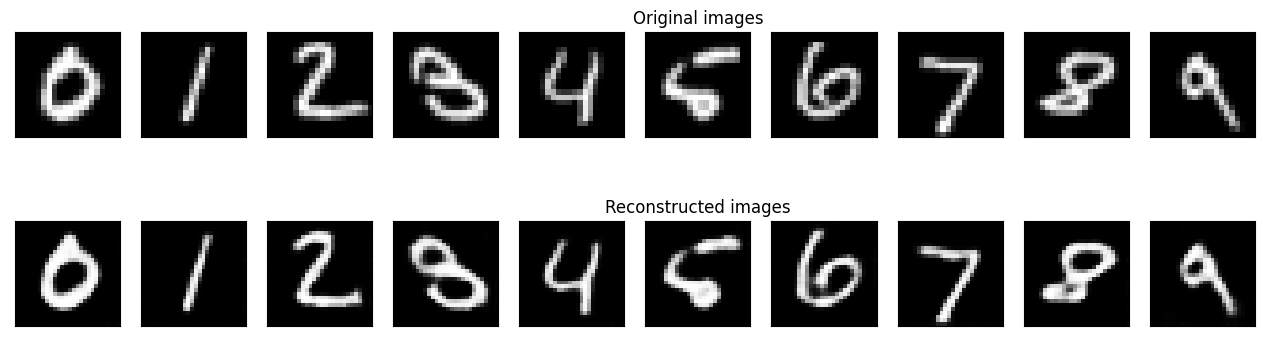

	 partial train loss (single batch): 0.005674
	 partial train loss (single batch): 0.005671
	 partial train loss (single batch): 0.005863
	 partial train loss (single batch): 0.005448
	 partial train loss (single batch): 0.005475
	 partial train loss (single batch): 0.005905
	 partial train loss (single batch): 0.005634
	 partial train loss (single batch): 0.005527
	 partial train loss (single batch): 0.005788
	 partial train loss (single batch): 0.005189
	 partial train loss (single batch): 0.005771
	 partial train loss (single batch): 0.005304
	 partial train loss (single batch): 0.006050
	 partial train loss (single batch): 0.005418
	 partial train loss (single batch): 0.005549
	 partial train loss (single batch): 0.005488
	 partial train loss (single batch): 0.005455
	 partial train loss (single batch): 0.005616
	 partial train loss (single batch): 0.005811
	 partial train loss (single batch): 0.005863
	 partial train loss (single batch): 0.005409
	 partial train loss (single batch

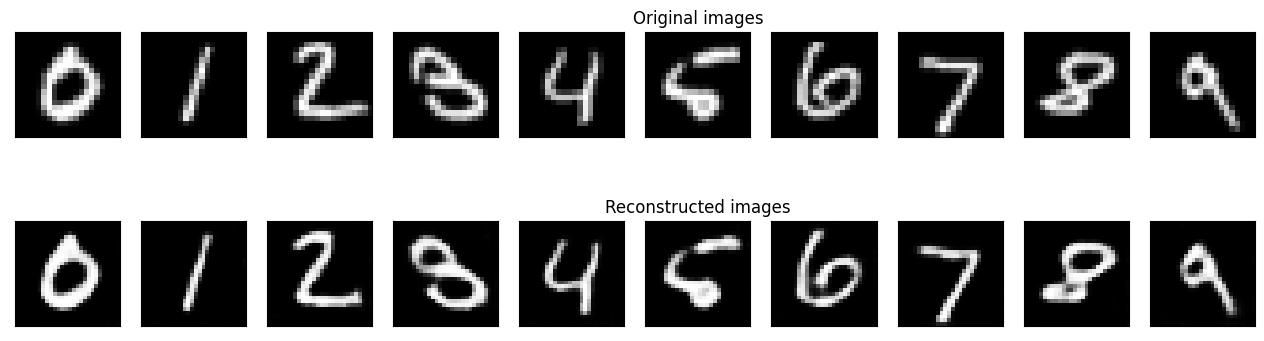

	 partial train loss (single batch): 0.005771
	 partial train loss (single batch): 0.005620
	 partial train loss (single batch): 0.005865
	 partial train loss (single batch): 0.005451
	 partial train loss (single batch): 0.005497
	 partial train loss (single batch): 0.005949
	 partial train loss (single batch): 0.005553
	 partial train loss (single batch): 0.005568
	 partial train loss (single batch): 0.005724
	 partial train loss (single batch): 0.005186
	 partial train loss (single batch): 0.005781
	 partial train loss (single batch): 0.005342
	 partial train loss (single batch): 0.006049
	 partial train loss (single batch): 0.005383
	 partial train loss (single batch): 0.005567
	 partial train loss (single batch): 0.005436
	 partial train loss (single batch): 0.005466
	 partial train loss (single batch): 0.005656
	 partial train loss (single batch): 0.005731
	 partial train loss (single batch): 0.005888
	 partial train loss (single batch): 0.005448
	 partial train loss (single batch

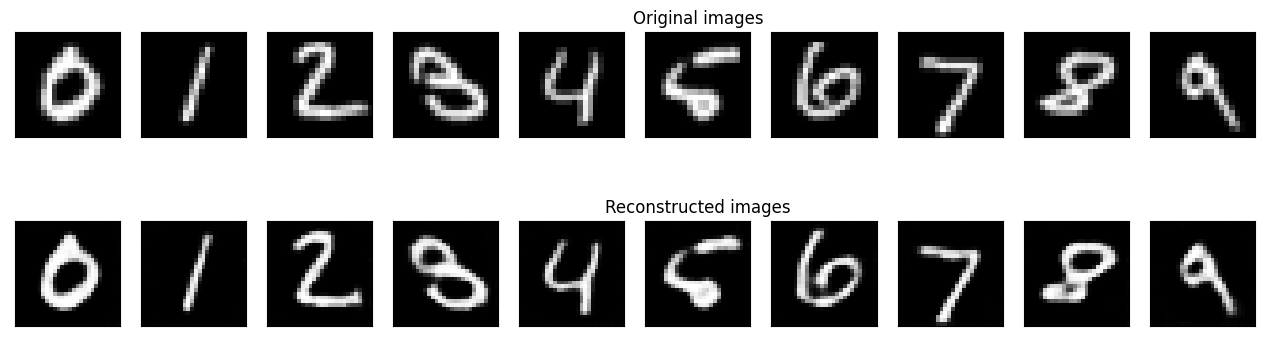

	 partial train loss (single batch): 0.005681
	 partial train loss (single batch): 0.005620
	 partial train loss (single batch): 0.005863
	 partial train loss (single batch): 0.005374
	 partial train loss (single batch): 0.005492
	 partial train loss (single batch): 0.005855
	 partial train loss (single batch): 0.005559
	 partial train loss (single batch): 0.005541
	 partial train loss (single batch): 0.005737
	 partial train loss (single batch): 0.005160
	 partial train loss (single batch): 0.005771
	 partial train loss (single batch): 0.005256
	 partial train loss (single batch): 0.006017
	 partial train loss (single batch): 0.005374
	 partial train loss (single batch): 0.005527
	 partial train loss (single batch): 0.005443
	 partial train loss (single batch): 0.005413
	 partial train loss (single batch): 0.005587
	 partial train loss (single batch): 0.005757
	 partial train loss (single batch): 0.005835
	 partial train loss (single batch): 0.005372
	 partial train loss (single batch

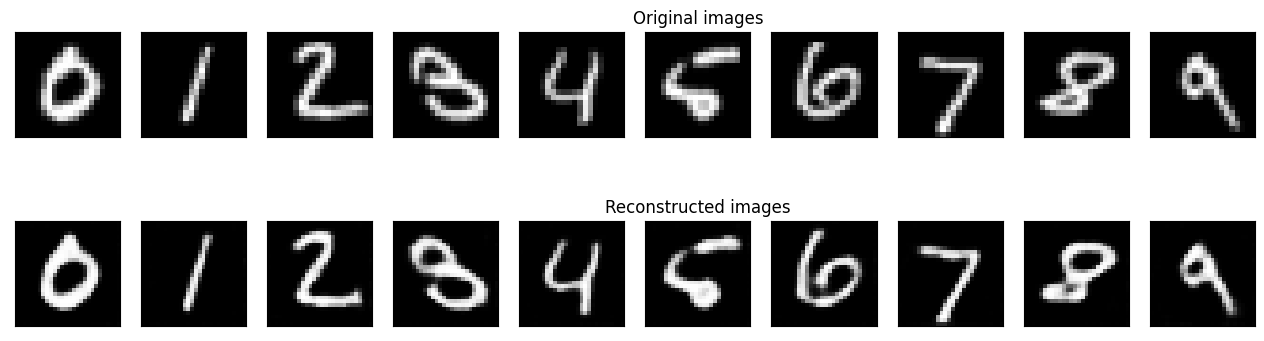

	 partial train loss (single batch): 0.005684
	 partial train loss (single batch): 0.005634
	 partial train loss (single batch): 0.005811
	 partial train loss (single batch): 0.005349
	 partial train loss (single batch): 0.005496
	 partial train loss (single batch): 0.005811
	 partial train loss (single batch): 0.005570
	 partial train loss (single batch): 0.005555
	 partial train loss (single batch): 0.005709
	 partial train loss (single batch): 0.005170
	 partial train loss (single batch): 0.005772
	 partial train loss (single batch): 0.005252
	 partial train loss (single batch): 0.006003
	 partial train loss (single batch): 0.005362
	 partial train loss (single batch): 0.005523
	 partial train loss (single batch): 0.005464
	 partial train loss (single batch): 0.005400
	 partial train loss (single batch): 0.005607
	 partial train loss (single batch): 0.005759
	 partial train loss (single batch): 0.005807
	 partial train loss (single batch): 0.005387
	 partial train loss (single batch

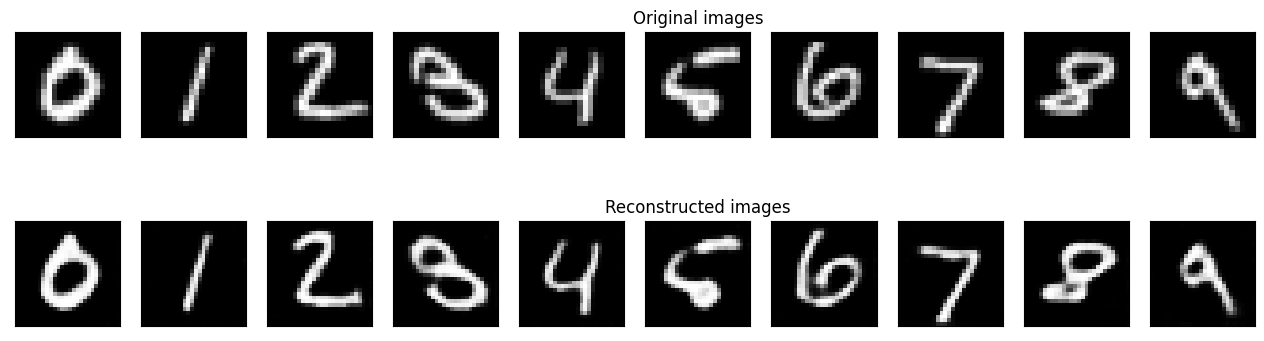

	 partial train loss (single batch): 0.005675
	 partial train loss (single batch): 0.005610
	 partial train loss (single batch): 0.005775
	 partial train loss (single batch): 0.005344
	 partial train loss (single batch): 0.005473
	 partial train loss (single batch): 0.005807
	 partial train loss (single batch): 0.005546
	 partial train loss (single batch): 0.005555
	 partial train loss (single batch): 0.005686
	 partial train loss (single batch): 0.005181
	 partial train loss (single batch): 0.005742
	 partial train loss (single batch): 0.005261
	 partial train loss (single batch): 0.005978
	 partial train loss (single batch): 0.005360
	 partial train loss (single batch): 0.005521
	 partial train loss (single batch): 0.005457
	 partial train loss (single batch): 0.005384
	 partial train loss (single batch): 0.005625
	 partial train loss (single batch): 0.005734
	 partial train loss (single batch): 0.005792
	 partial train loss (single batch): 0.005374
	 partial train loss (single batch

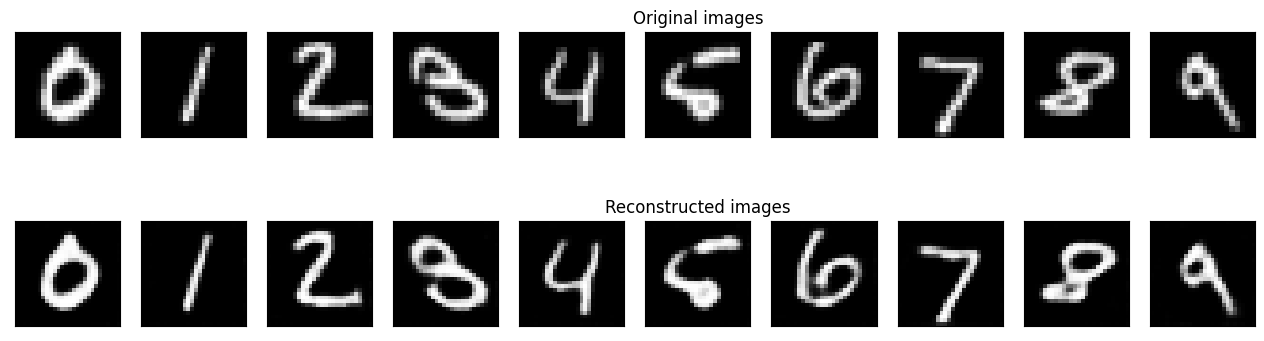

	 partial train loss (single batch): 0.005613
	 partial train loss (single batch): 0.005640
	 partial train loss (single batch): 0.005707
	 partial train loss (single batch): 0.005336
	 partial train loss (single batch): 0.005441
	 partial train loss (single batch): 0.005813
	 partial train loss (single batch): 0.005497
	 partial train loss (single batch): 0.005568
	 partial train loss (single batch): 0.005644
	 partial train loss (single batch): 0.005218
	 partial train loss (single batch): 0.005711
	 partial train loss (single batch): 0.005269
	 partial train loss (single batch): 0.005982
	 partial train loss (single batch): 0.005373
	 partial train loss (single batch): 0.005524
	 partial train loss (single batch): 0.005450
	 partial train loss (single batch): 0.005379
	 partial train loss (single batch): 0.005649
	 partial train loss (single batch): 0.005723
	 partial train loss (single batch): 0.005806
	 partial train loss (single batch): 0.005364
	 partial train loss (single batch

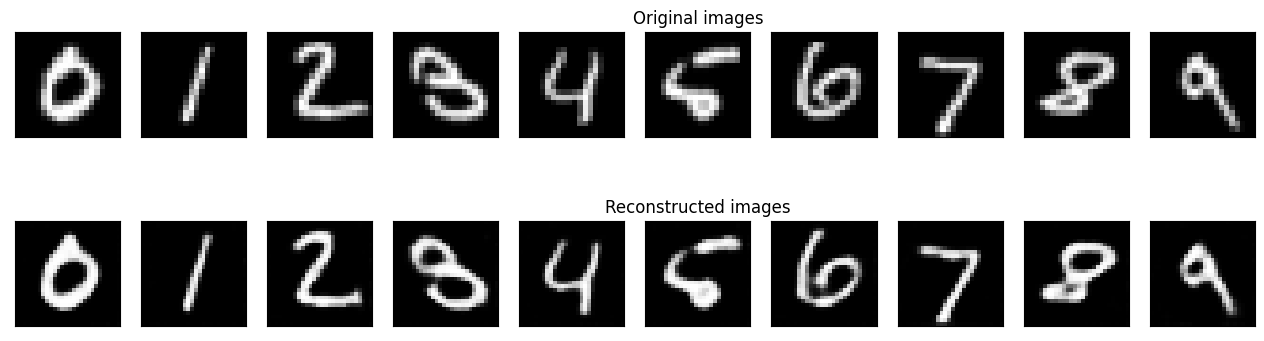

	 partial train loss (single batch): 0.005577
	 partial train loss (single batch): 0.005609
	 partial train loss (single batch): 0.005658
	 partial train loss (single batch): 0.005297
	 partial train loss (single batch): 0.005410
	 partial train loss (single batch): 0.005749
	 partial train loss (single batch): 0.005456
	 partial train loss (single batch): 0.005511
	 partial train loss (single batch): 0.005605
	 partial train loss (single batch): 0.005175
	 partial train loss (single batch): 0.005650
	 partial train loss (single batch): 0.005247
	 partial train loss (single batch): 0.005943
	 partial train loss (single batch): 0.005331
	 partial train loss (single batch): 0.005495
	 partial train loss (single batch): 0.005390
	 partial train loss (single batch): 0.005358
	 partial train loss (single batch): 0.005599
	 partial train loss (single batch): 0.005681
	 partial train loss (single batch): 0.005780
	 partial train loss (single batch): 0.005754
	 partial train loss (single batch

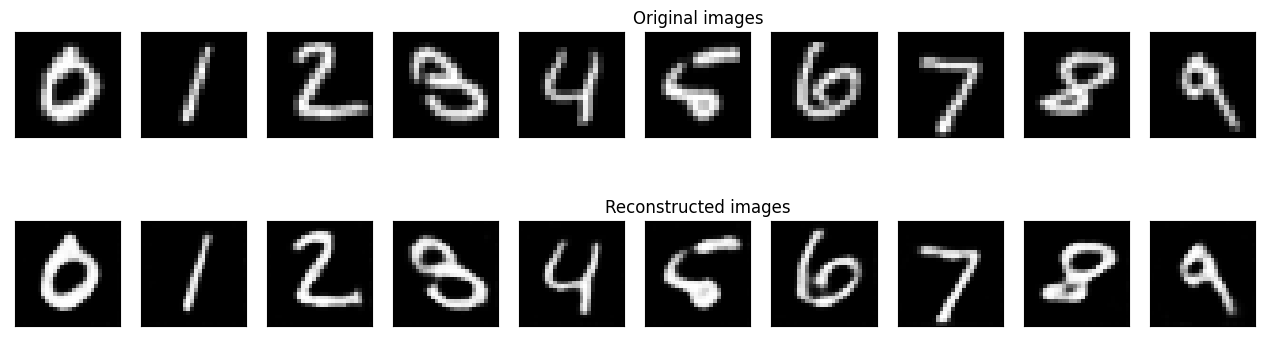

	 partial train loss (single batch): 0.005553
	 partial train loss (single batch): 0.005615
	 partial train loss (single batch): 0.005620
	 partial train loss (single batch): 0.005289
	 partial train loss (single batch): 0.005406
	 partial train loss (single batch): 0.005695
	 partial train loss (single batch): 0.005462
	 partial train loss (single batch): 0.005483
	 partial train loss (single batch): 0.005594
	 partial train loss (single batch): 0.005128
	 partial train loss (single batch): 0.005647
	 partial train loss (single batch): 0.005220
	 partial train loss (single batch): 0.005903
	 partial train loss (single batch): 0.005308
	 partial train loss (single batch): 0.005462
	 partial train loss (single batch): 0.005385
	 partial train loss (single batch): 0.005319
	 partial train loss (single batch): 0.005587
	 partial train loss (single batch): 0.005682
	 partial train loss (single batch): 0.005728
	 partial train loss (single batch): 0.005265
	 partial train loss (single batch

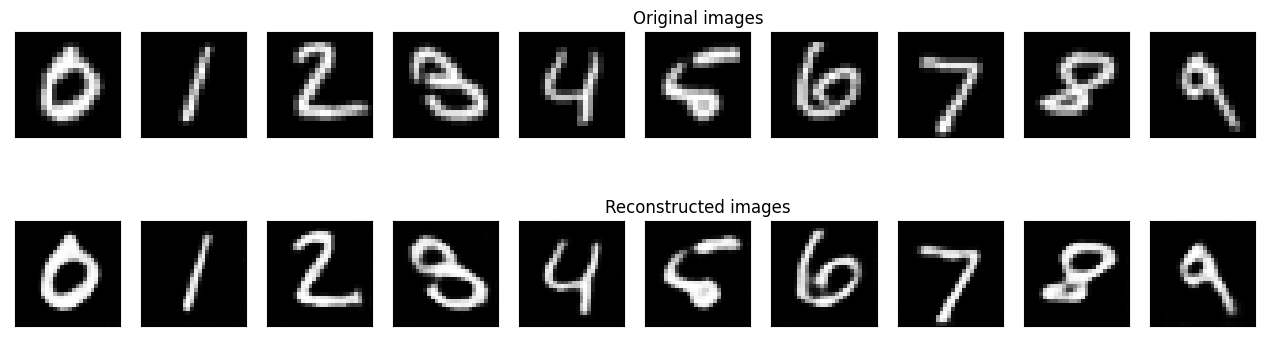

	 partial train loss (single batch): 0.005535
	 partial train loss (single batch): 0.005619
	 partial train loss (single batch): 0.005610
	 partial train loss (single batch): 0.005282
	 partial train loss (single batch): 0.005422
	 partial train loss (single batch): 0.005681
	 partial train loss (single batch): 0.005465
	 partial train loss (single batch): 0.005494
	 partial train loss (single batch): 0.005606
	 partial train loss (single batch): 0.005129
	 partial train loss (single batch): 0.005675
	 partial train loss (single batch): 0.005209
	 partial train loss (single batch): 0.005927
	 partial train loss (single batch): 0.005383
	 partial train loss (single batch): 0.005543
	 partial train loss (single batch): 0.005411
	 partial train loss (single batch): 0.005334
	 partial train loss (single batch): 0.005739
	 partial train loss (single batch): 0.005713
	 partial train loss (single batch): 0.005752
	 partial train loss (single batch): 0.005404
	 partial train loss (single batch

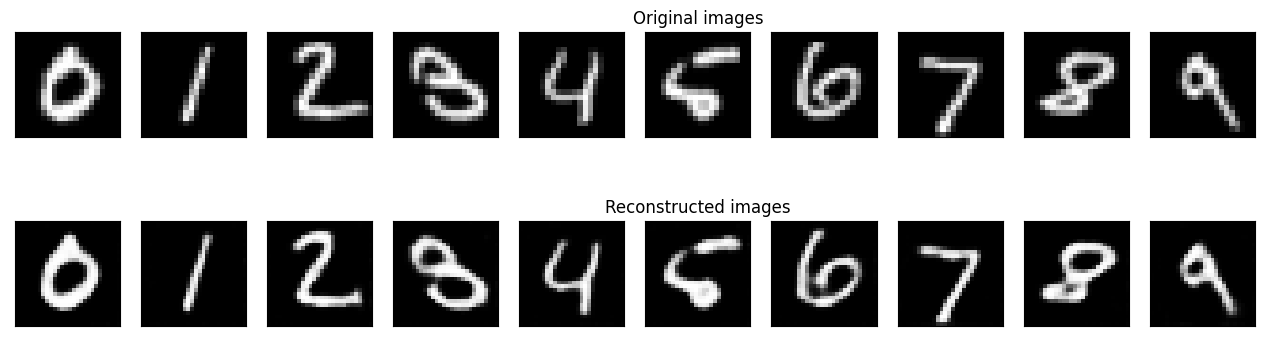

	 partial train loss (single batch): 0.005543
	 partial train loss (single batch): 0.005554
	 partial train loss (single batch): 0.005574
	 partial train loss (single batch): 0.005464
	 partial train loss (single batch): 0.005725
	 partial train loss (single batch): 0.005747
	 partial train loss (single batch): 0.005522
	 partial train loss (single batch): 0.005746
	 partial train loss (single batch): 0.005709
	 partial train loss (single batch): 0.005226
	 partial train loss (single batch): 0.005862
	 partial train loss (single batch): 0.005302
	 partial train loss (single batch): 0.006031
	 partial train loss (single batch): 0.005404
	 partial train loss (single batch): 0.005557
	 partial train loss (single batch): 0.005483
	 partial train loss (single batch): 0.005362
	 partial train loss (single batch): 0.005659
	 partial train loss (single batch): 0.005743
	 partial train loss (single batch): 0.005761
	 partial train loss (single batch): 0.005299
	 partial train loss (single batch

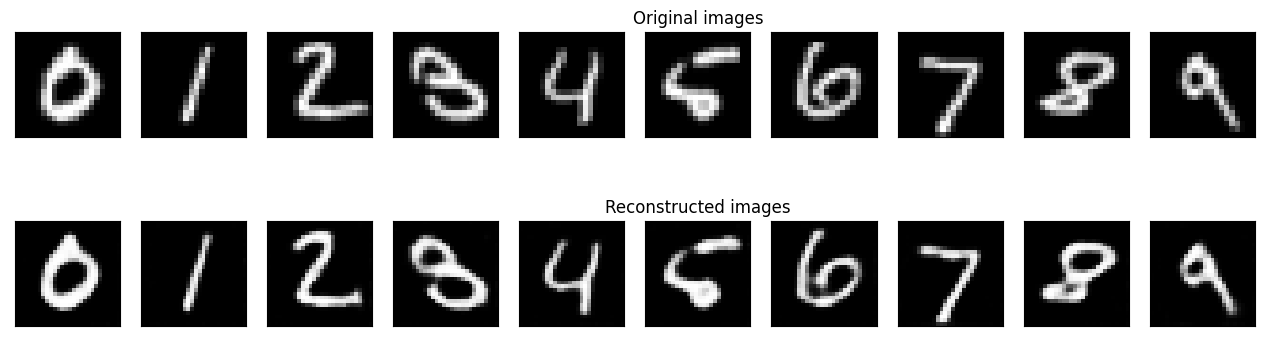

	 partial train loss (single batch): 0.005550
	 partial train loss (single batch): 0.005490
	 partial train loss (single batch): 0.005543
	 partial train loss (single batch): 0.005238
	 partial train loss (single batch): 0.005375
	 partial train loss (single batch): 0.005615
	 partial train loss (single batch): 0.005455
	 partial train loss (single batch): 0.005429
	 partial train loss (single batch): 0.005628
	 partial train loss (single batch): 0.005104
	 partial train loss (single batch): 0.005684
	 partial train loss (single batch): 0.005212
	 partial train loss (single batch): 0.005909
	 partial train loss (single batch): 0.005273
	 partial train loss (single batch): 0.005501
	 partial train loss (single batch): 0.005352
	 partial train loss (single batch): 0.005307
	 partial train loss (single batch): 0.005599
	 partial train loss (single batch): 0.005711
	 partial train loss (single batch): 0.005718
	 partial train loss (single batch): 0.005301
	 partial train loss (single batch

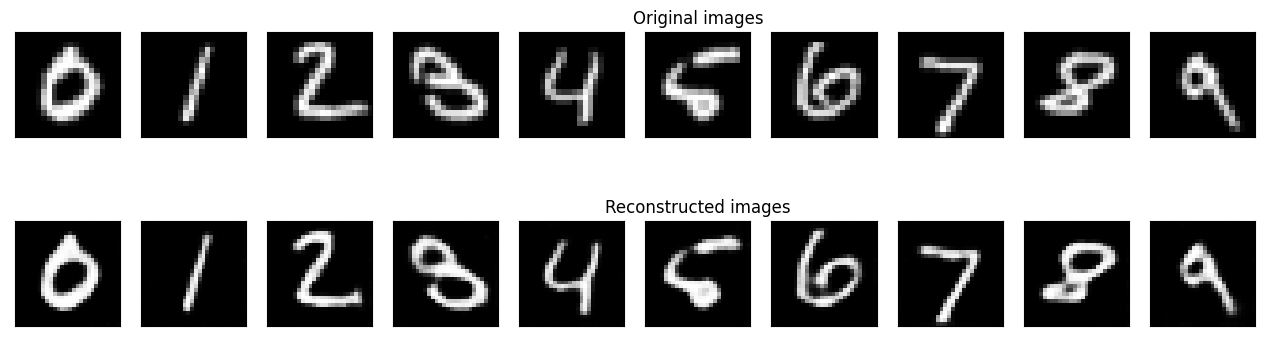

	 partial train loss (single batch): 0.005534
	 partial train loss (single batch): 0.005458
	 partial train loss (single batch): 0.005531
	 partial train loss (single batch): 0.005241
	 partial train loss (single batch): 0.005351
	 partial train loss (single batch): 0.005618
	 partial train loss (single batch): 0.005466
	 partial train loss (single batch): 0.005425
	 partial train loss (single batch): 0.005610
	 partial train loss (single batch): 0.005100
	 partial train loss (single batch): 0.005626
	 partial train loss (single batch): 0.005221
	 partial train loss (single batch): 0.005886
	 partial train loss (single batch): 0.005254
	 partial train loss (single batch): 0.005486
	 partial train loss (single batch): 0.005333
	 partial train loss (single batch): 0.005303
	 partial train loss (single batch): 0.005706
	 partial train loss (single batch): 0.006023
	 partial train loss (single batch): 0.005781
	 partial train loss (single batch): 0.005432
	 partial train loss (single batch

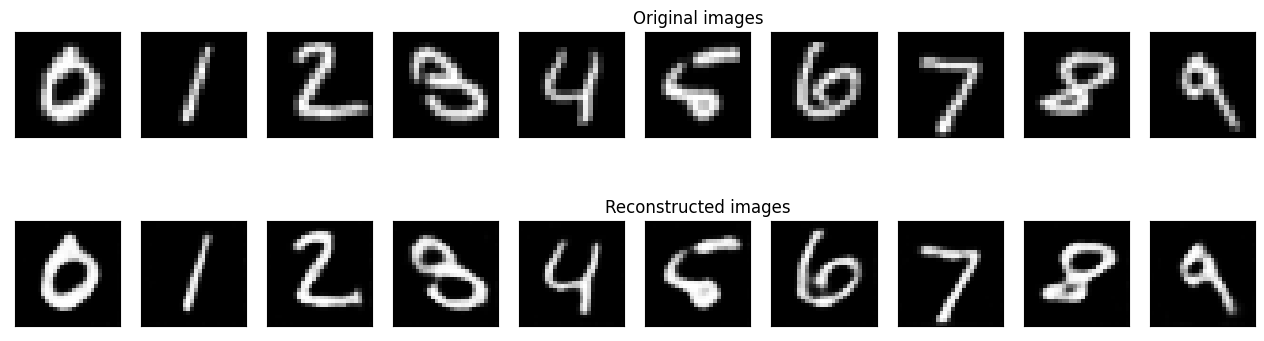

	 partial train loss (single batch): 0.005474
	 partial train loss (single batch): 0.005507
	 partial train loss (single batch): 0.005482
	 partial train loss (single batch): 0.005278
	 partial train loss (single batch): 0.005279
	 partial train loss (single batch): 0.005670
	 partial train loss (single batch): 0.005426
	 partial train loss (single batch): 0.005400
	 partial train loss (single batch): 0.005549
	 partial train loss (single batch): 0.005122
	 partial train loss (single batch): 0.005530
	 partial train loss (single batch): 0.005226
	 partial train loss (single batch): 0.005883
	 partial train loss (single batch): 0.005263
	 partial train loss (single batch): 0.005453
	 partial train loss (single batch): 0.005325
	 partial train loss (single batch): 0.005275
	 partial train loss (single batch): 0.005606
	 partial train loss (single batch): 0.005640
	 partial train loss (single batch): 0.005740
	 partial train loss (single batch): 0.005195
	 partial train loss (single batch

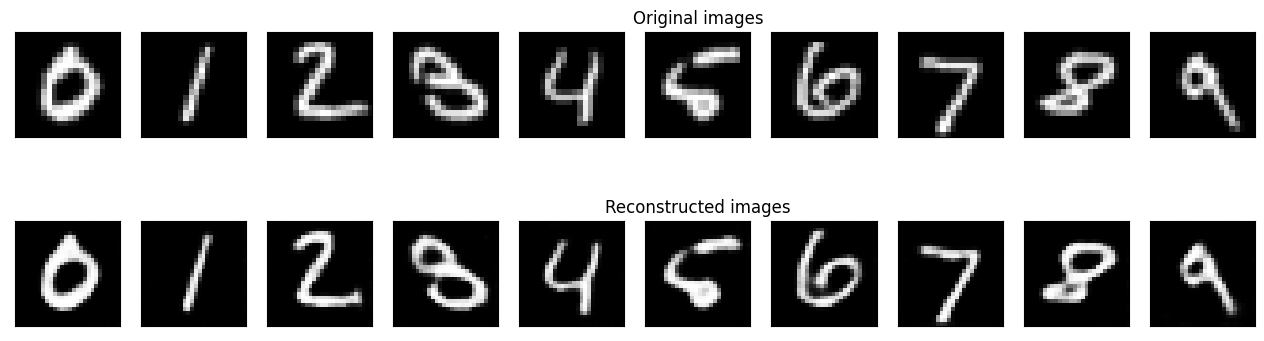

	 partial train loss (single batch): 0.005423
	 partial train loss (single batch): 0.005639
	 partial train loss (single batch): 0.005509
	 partial train loss (single batch): 0.005268
	 partial train loss (single batch): 0.005284
	 partial train loss (single batch): 0.005684
	 partial train loss (single batch): 0.005384
	 partial train loss (single batch): 0.005383
	 partial train loss (single batch): 0.005519
	 partial train loss (single batch): 0.005131
	 partial train loss (single batch): 0.005497
	 partial train loss (single batch): 0.005217
	 partial train loss (single batch): 0.005891
	 partial train loss (single batch): 0.005241
	 partial train loss (single batch): 0.005425
	 partial train loss (single batch): 0.005233
	 partial train loss (single batch): 0.005304
	 partial train loss (single batch): 0.005544
	 partial train loss (single batch): 0.005634
	 partial train loss (single batch): 0.005710
	 partial train loss (single batch): 0.005230
	 partial train loss (single batch

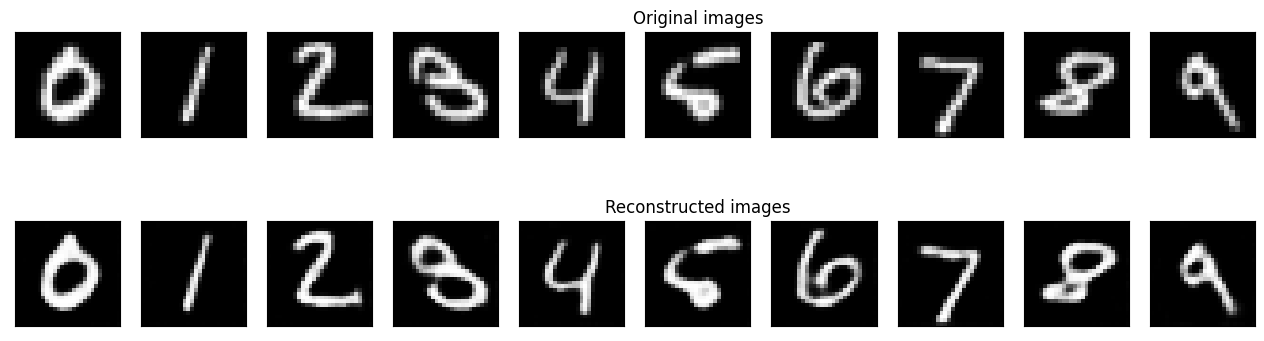

	 partial train loss (single batch): 0.005427
	 partial train loss (single batch): 0.005461
	 partial train loss (single batch): 0.005485
	 partial train loss (single batch): 0.005218
	 partial train loss (single batch): 0.005257
	 partial train loss (single batch): 0.005599
	 partial train loss (single batch): 0.005368
	 partial train loss (single batch): 0.005389
	 partial train loss (single batch): 0.005524
	 partial train loss (single batch): 0.005064
	 partial train loss (single batch): 0.005568
	 partial train loss (single batch): 0.005176
	 partial train loss (single batch): 0.005847
	 partial train loss (single batch): 0.005205
	 partial train loss (single batch): 0.005415
	 partial train loss (single batch): 0.005272
	 partial train loss (single batch): 0.005246
	 partial train loss (single batch): 0.005532
	 partial train loss (single batch): 0.005636
	 partial train loss (single batch): 0.005679
	 partial train loss (single batch): 0.005204
	 partial train loss (single batch

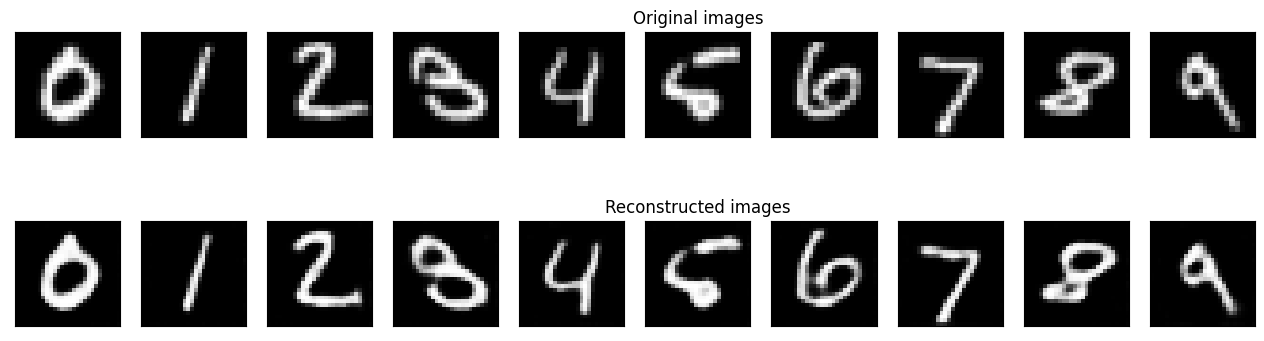

	 partial train loss (single batch): 0.005441
	 partial train loss (single batch): 0.005418
	 partial train loss (single batch): 0.005461
	 partial train loss (single batch): 0.005155
	 partial train loss (single batch): 0.005268
	 partial train loss (single batch): 0.005575
	 partial train loss (single batch): 0.005352
	 partial train loss (single batch): 0.005366
	 partial train loss (single batch): 0.005553
	 partial train loss (single batch): 0.005038
	 partial train loss (single batch): 0.005634
	 partial train loss (single batch): 0.005181
	 partial train loss (single batch): 0.005874
	 partial train loss (single batch): 0.005205
	 partial train loss (single batch): 0.005448
	 partial train loss (single batch): 0.005290
	 partial train loss (single batch): 0.005273
	 partial train loss (single batch): 0.005579
	 partial train loss (single batch): 0.005672
	 partial train loss (single batch): 0.005688
	 partial train loss (single batch): 0.005260
	 partial train loss (single batch

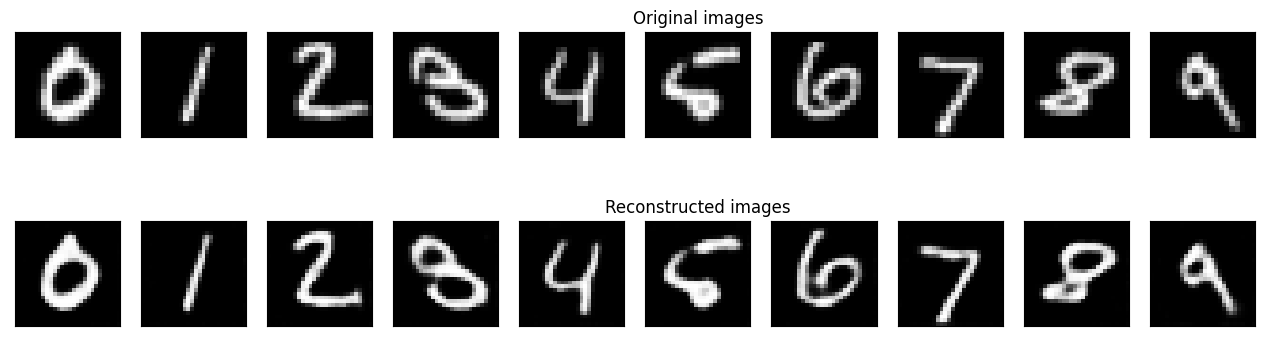

	 partial train loss (single batch): 0.005444
	 partial train loss (single batch): 0.005512
	 partial train loss (single batch): 0.005472
	 partial train loss (single batch): 0.005230
	 partial train loss (single batch): 0.005275
	 partial train loss (single batch): 0.005617
	 partial train loss (single batch): 0.005394
	 partial train loss (single batch): 0.005406
	 partial train loss (single batch): 0.005528
	 partial train loss (single batch): 0.005075
	 partial train loss (single batch): 0.005560
	 partial train loss (single batch): 0.005176
	 partial train loss (single batch): 0.005873
	 partial train loss (single batch): 0.005186
	 partial train loss (single batch): 0.005426
	 partial train loss (single batch): 0.005246
	 partial train loss (single batch): 0.005238
	 partial train loss (single batch): 0.005539
	 partial train loss (single batch): 0.005606
	 partial train loss (single batch): 0.005716
	 partial train loss (single batch): 0.005202
	 partial train loss (single batch

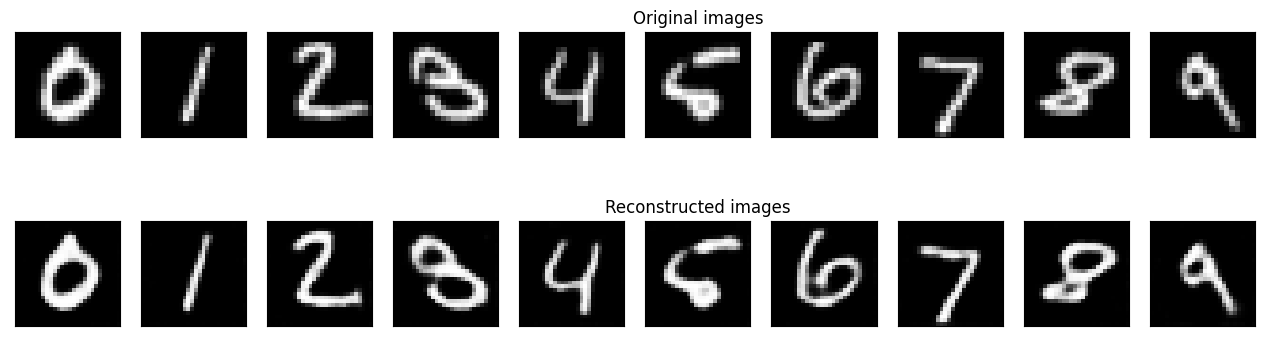

	 partial train loss (single batch): 0.005464
	 partial train loss (single batch): 0.005473
	 partial train loss (single batch): 0.005465
	 partial train loss (single batch): 0.005192
	 partial train loss (single batch): 0.005275
	 partial train loss (single batch): 0.005602
	 partial train loss (single batch): 0.005381
	 partial train loss (single batch): 0.005406
	 partial train loss (single batch): 0.005526
	 partial train loss (single batch): 0.005052
	 partial train loss (single batch): 0.005587
	 partial train loss (single batch): 0.005167
	 partial train loss (single batch): 0.005868
	 partial train loss (single batch): 0.005169
	 partial train loss (single batch): 0.005422
	 partial train loss (single batch): 0.005222
	 partial train loss (single batch): 0.005233
	 partial train loss (single batch): 0.005531
	 partial train loss (single batch): 0.005612
	 partial train loss (single batch): 0.005674
	 partial train loss (single batch): 0.005210
	 partial train loss (single batch

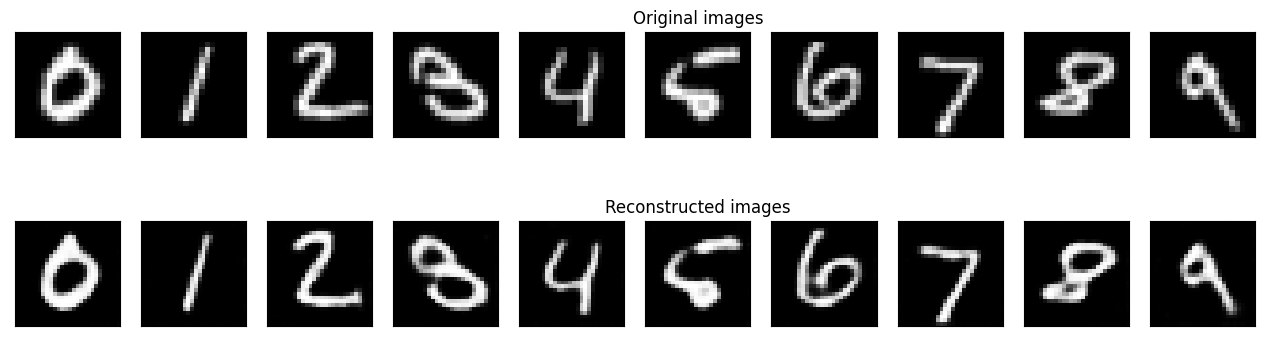

	 partial train loss (single batch): 0.005451
	 partial train loss (single batch): 0.005510
	 partial train loss (single batch): 0.005445
	 partial train loss (single batch): 0.005193
	 partial train loss (single batch): 0.005269
	 partial train loss (single batch): 0.005584
	 partial train loss (single batch): 0.005374
	 partial train loss (single batch): 0.005421
	 partial train loss (single batch): 0.005491
	 partial train loss (single batch): 0.005059
	 partial train loss (single batch): 0.005555
	 partial train loss (single batch): 0.005151
	 partial train loss (single batch): 0.005878
	 partial train loss (single batch): 0.005147
	 partial train loss (single batch): 0.005404
	 partial train loss (single batch): 0.005221
	 partial train loss (single batch): 0.005221
	 partial train loss (single batch): 0.005542
	 partial train loss (single batch): 0.005603
	 partial train loss (single batch): 0.005661
	 partial train loss (single batch): 0.005204
	 partial train loss (single batch

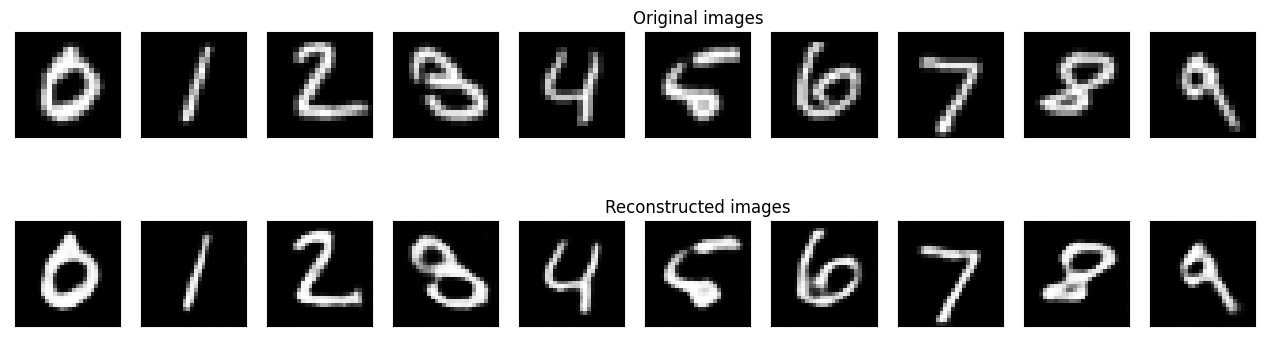

	 partial train loss (single batch): 0.005935
	 partial train loss (single batch): 0.005951
	 partial train loss (single batch): 0.005757
	 partial train loss (single batch): 0.005619
	 partial train loss (single batch): 0.005492
	 partial train loss (single batch): 0.006062
	 partial train loss (single batch): 0.005716
	 partial train loss (single batch): 0.005548
	 partial train loss (single batch): 0.005791
	 partial train loss (single batch): 0.005258
	 partial train loss (single batch): 0.005751
	 partial train loss (single batch): 0.005408
	 partial train loss (single batch): 0.006039
	 partial train loss (single batch): 0.005374
	 partial train loss (single batch): 0.005545
	 partial train loss (single batch): 0.005249
	 partial train loss (single batch): 0.005560
	 partial train loss (single batch): 0.005502
	 partial train loss (single batch): 0.005776
	 partial train loss (single batch): 0.005698
	 partial train loss (single batch): 0.005375
	 partial train loss (single batch

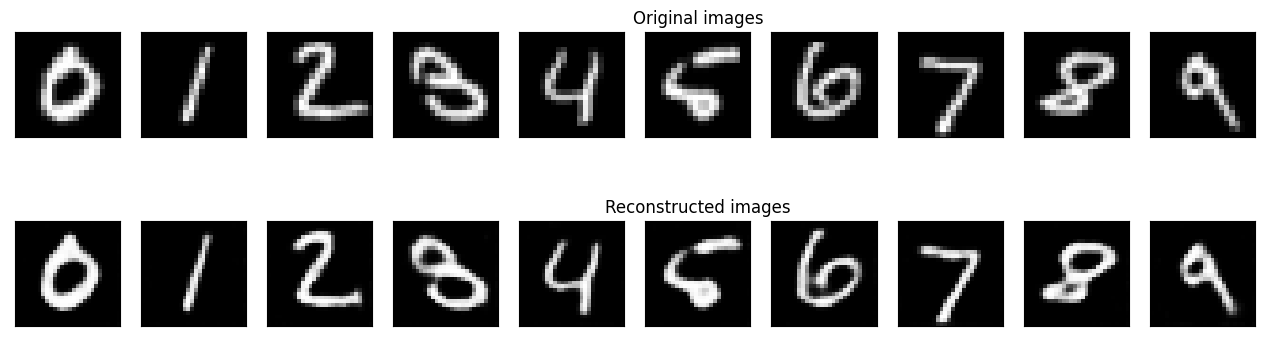

	 partial train loss (single batch): 0.005404
	 partial train loss (single batch): 0.005480
	 partial train loss (single batch): 0.005343
	 partial train loss (single batch): 0.005171
	 partial train loss (single batch): 0.005182
	 partial train loss (single batch): 0.005546
	 partial train loss (single batch): 0.005310
	 partial train loss (single batch): 0.005325
	 partial train loss (single batch): 0.005427
	 partial train loss (single batch): 0.005051
	 partial train loss (single batch): 0.005464
	 partial train loss (single batch): 0.005116
	 partial train loss (single batch): 0.005824
	 partial train loss (single batch): 0.005086
	 partial train loss (single batch): 0.005340
	 partial train loss (single batch): 0.005134
	 partial train loss (single batch): 0.005198
	 partial train loss (single batch): 0.005442
	 partial train loss (single batch): 0.005527
	 partial train loss (single batch): 0.005594
	 partial train loss (single batch): 0.005132
	 partial train loss (single batch

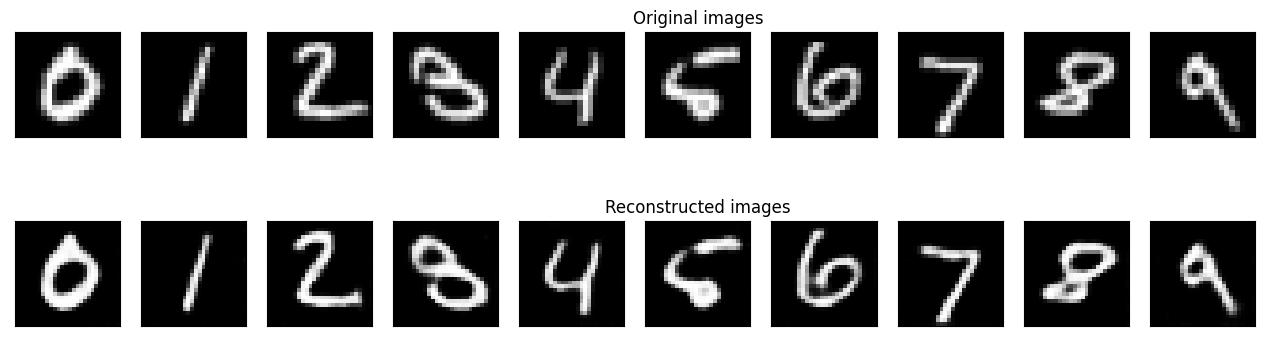

	 partial train loss (single batch): 0.005461
	 partial train loss (single batch): 0.005437
	 partial train loss (single batch): 0.005395
	 partial train loss (single batch): 0.005170
	 partial train loss (single batch): 0.005177
	 partial train loss (single batch): 0.005578
	 partial train loss (single batch): 0.005383
	 partial train loss (single batch): 0.005273
	 partial train loss (single batch): 0.005468
	 partial train loss (single batch): 0.005079
	 partial train loss (single batch): 0.005480
	 partial train loss (single batch): 0.005138
	 partial train loss (single batch): 0.005847
	 partial train loss (single batch): 0.005099
	 partial train loss (single batch): 0.005363
	 partial train loss (single batch): 0.005108
	 partial train loss (single batch): 0.005202
	 partial train loss (single batch): 0.005434
	 partial train loss (single batch): 0.005536
	 partial train loss (single batch): 0.005593
	 partial train loss (single batch): 0.005163
	 partial train loss (single batch

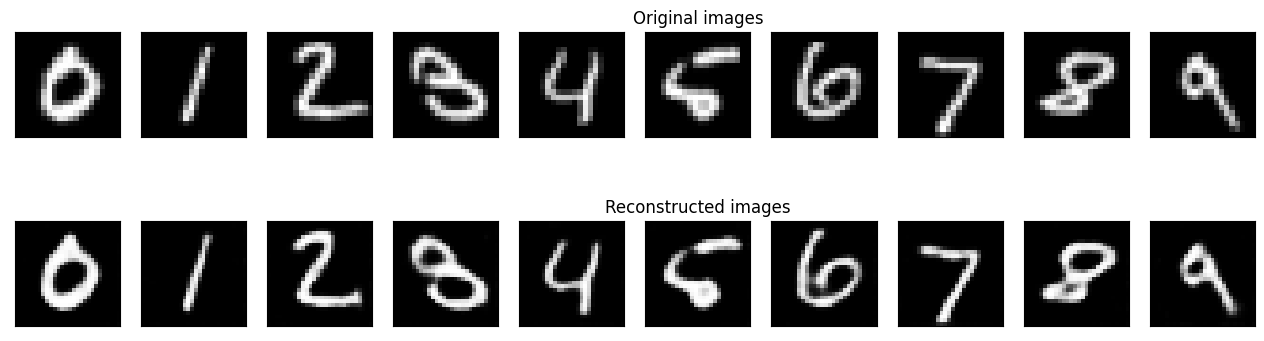

	 partial train loss (single batch): 0.005466
	 partial train loss (single batch): 0.005388
	 partial train loss (single batch): 0.005441
	 partial train loss (single batch): 0.005153
	 partial train loss (single batch): 0.005186
	 partial train loss (single batch): 0.005581
	 partial train loss (single batch): 0.005320
	 partial train loss (single batch): 0.005242
	 partial train loss (single batch): 0.005526
	 partial train loss (single batch): 0.004989
	 partial train loss (single batch): 0.005517
	 partial train loss (single batch): 0.005105
	 partial train loss (single batch): 0.005852
	 partial train loss (single batch): 0.005101
	 partial train loss (single batch): 0.005340
	 partial train loss (single batch): 0.005111
	 partial train loss (single batch): 0.005165
	 partial train loss (single batch): 0.005430
	 partial train loss (single batch): 0.005554
	 partial train loss (single batch): 0.005597
	 partial train loss (single batch): 0.005110
	 partial train loss (single batch

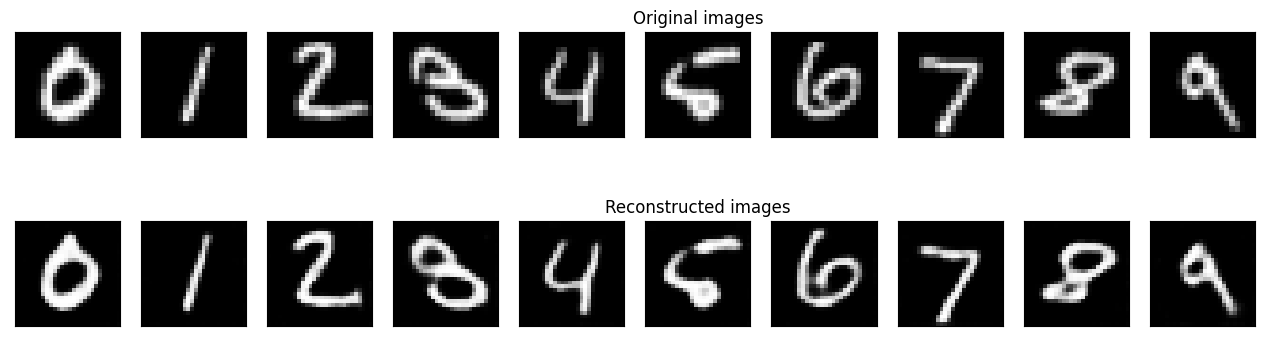

	 partial train loss (single batch): 0.005406
	 partial train loss (single batch): 0.005390
	 partial train loss (single batch): 0.005367
	 partial train loss (single batch): 0.005125
	 partial train loss (single batch): 0.005187
	 partial train loss (single batch): 0.005540
	 partial train loss (single batch): 0.005307
	 partial train loss (single batch): 0.005322
	 partial train loss (single batch): 0.005452
	 partial train loss (single batch): 0.004975
	 partial train loss (single batch): 0.005516
	 partial train loss (single batch): 0.005080
	 partial train loss (single batch): 0.005815
	 partial train loss (single batch): 0.005074
	 partial train loss (single batch): 0.005293
	 partial train loss (single batch): 0.005117
	 partial train loss (single batch): 0.005156
	 partial train loss (single batch): 0.005449
	 partial train loss (single batch): 0.005546
	 partial train loss (single batch): 0.005569
	 partial train loss (single batch): 0.005129
	 partial train loss (single batch

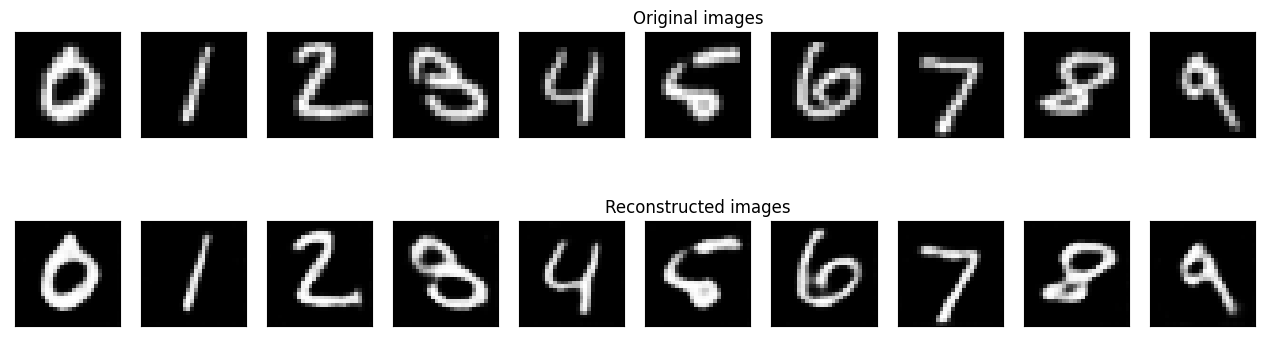

	 partial train loss (single batch): 0.005418
	 partial train loss (single batch): 0.005378
	 partial train loss (single batch): 0.005328
	 partial train loss (single batch): 0.005128
	 partial train loss (single batch): 0.005184
	 partial train loss (single batch): 0.005546
	 partial train loss (single batch): 0.005308
	 partial train loss (single batch): 0.005324
	 partial train loss (single batch): 0.005448
	 partial train loss (single batch): 0.004983
	 partial train loss (single batch): 0.005523
	 partial train loss (single batch): 0.005077
	 partial train loss (single batch): 0.005802
	 partial train loss (single batch): 0.005073
	 partial train loss (single batch): 0.005280
	 partial train loss (single batch): 0.005109
	 partial train loss (single batch): 0.005151
	 partial train loss (single batch): 0.005431
	 partial train loss (single batch): 0.005545
	 partial train loss (single batch): 0.005539
	 partial train loss (single batch): 0.005132
	 partial train loss (single batch

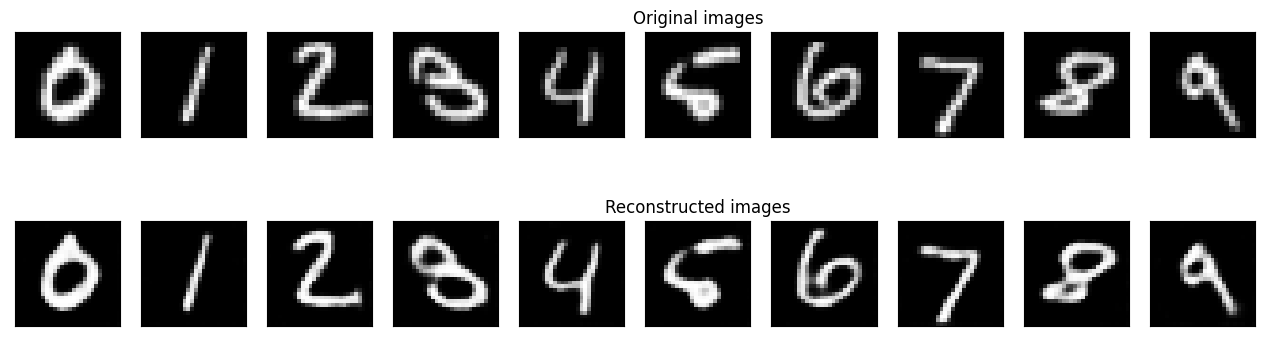

	 partial train loss (single batch): 0.005404
	 partial train loss (single batch): 0.005348
	 partial train loss (single batch): 0.005330
	 partial train loss (single batch): 0.005119
	 partial train loss (single batch): 0.005185
	 partial train loss (single batch): 0.005561
	 partial train loss (single batch): 0.005277
	 partial train loss (single batch): 0.005338
	 partial train loss (single batch): 0.005448
	 partial train loss (single batch): 0.004961
	 partial train loss (single batch): 0.005544
	 partial train loss (single batch): 0.005074
	 partial train loss (single batch): 0.005797
	 partial train loss (single batch): 0.005091
	 partial train loss (single batch): 0.005289
	 partial train loss (single batch): 0.005104
	 partial train loss (single batch): 0.005175
	 partial train loss (single batch): 0.005429
	 partial train loss (single batch): 0.005560
	 partial train loss (single batch): 0.005522
	 partial train loss (single batch): 0.005144
	 partial train loss (single batch

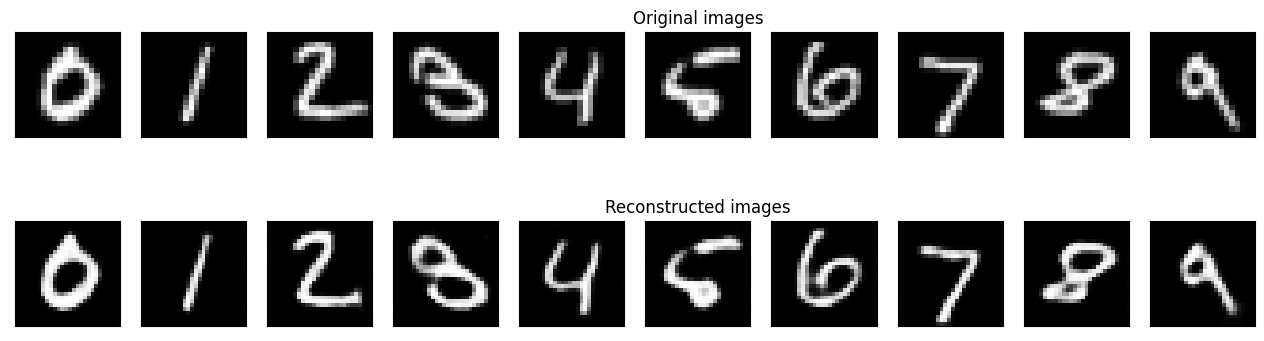

	 partial train loss (single batch): 0.005418
	 partial train loss (single batch): 0.005382
	 partial train loss (single batch): 0.005318
	 partial train loss (single batch): 0.005143
	 partial train loss (single batch): 0.005172
	 partial train loss (single batch): 0.005560
	 partial train loss (single batch): 0.005315
	 partial train loss (single batch): 0.005321
	 partial train loss (single batch): 0.005460
	 partial train loss (single batch): 0.004992
	 partial train loss (single batch): 0.005541
	 partial train loss (single batch): 0.005074
	 partial train loss (single batch): 0.005813
	 partial train loss (single batch): 0.005088
	 partial train loss (single batch): 0.005274
	 partial train loss (single batch): 0.005096
	 partial train loss (single batch): 0.005159
	 partial train loss (single batch): 0.005409
	 partial train loss (single batch): 0.005503
	 partial train loss (single batch): 0.005534
	 partial train loss (single batch): 0.005147
	 partial train loss (single batch

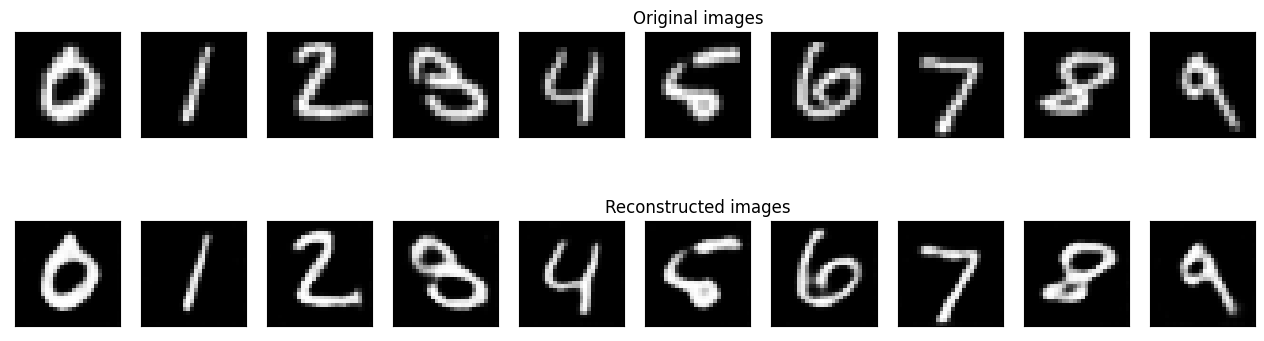

	 partial train loss (single batch): 0.005419
	 partial train loss (single batch): 0.005379
	 partial train loss (single batch): 0.005346
	 partial train loss (single batch): 0.005133
	 partial train loss (single batch): 0.005203
	 partial train loss (single batch): 0.005566
	 partial train loss (single batch): 0.005318
	 partial train loss (single batch): 0.005349
	 partial train loss (single batch): 0.005468
	 partial train loss (single batch): 0.004977
	 partial train loss (single batch): 0.005550
	 partial train loss (single batch): 0.005083
	 partial train loss (single batch): 0.005838
	 partial train loss (single batch): 0.005094
	 partial train loss (single batch): 0.005301
	 partial train loss (single batch): 0.005081
	 partial train loss (single batch): 0.005164
	 partial train loss (single batch): 0.005423
	 partial train loss (single batch): 0.005510
	 partial train loss (single batch): 0.005538
	 partial train loss (single batch): 0.005157
	 partial train loss (single batch

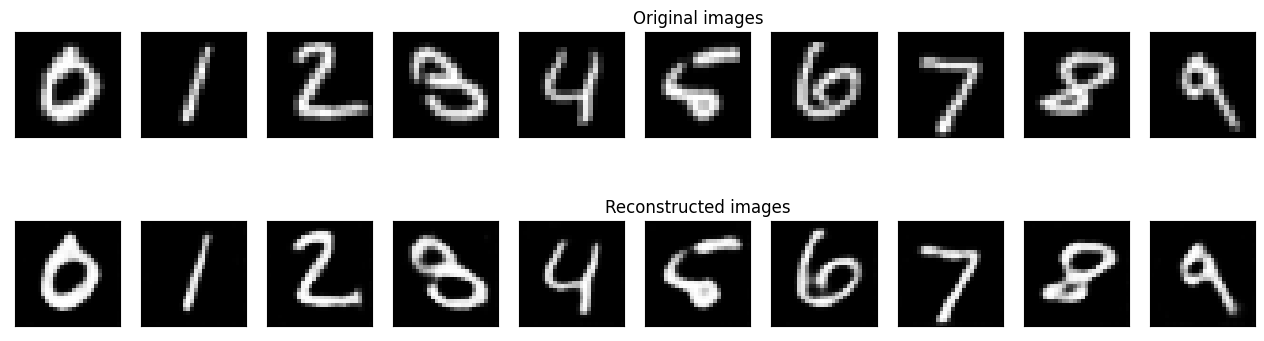

	 partial train loss (single batch): 0.005366
	 partial train loss (single batch): 0.005340
	 partial train loss (single batch): 0.005308
	 partial train loss (single batch): 0.005112
	 partial train loss (single batch): 0.005176
	 partial train loss (single batch): 0.005529
	 partial train loss (single batch): 0.005287
	 partial train loss (single batch): 0.005311
	 partial train loss (single batch): 0.005469
	 partial train loss (single batch): 0.004939
	 partial train loss (single batch): 0.005540
	 partial train loss (single batch): 0.005090
	 partial train loss (single batch): 0.005790
	 partial train loss (single batch): 0.005088
	 partial train loss (single batch): 0.005294
	 partial train loss (single batch): 0.005054
	 partial train loss (single batch): 0.005156
	 partial train loss (single batch): 0.005431
	 partial train loss (single batch): 0.005548
	 partial train loss (single batch): 0.005504
	 partial train loss (single batch): 0.005166
	 partial train loss (single batch

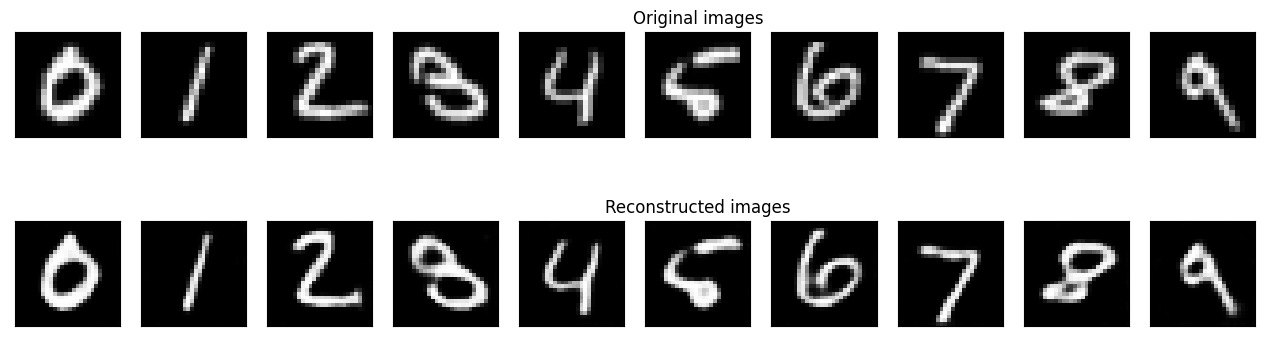

	 partial train loss (single batch): 0.005362
	 partial train loss (single batch): 0.005307
	 partial train loss (single batch): 0.005309
	 partial train loss (single batch): 0.005089
	 partial train loss (single batch): 0.005150
	 partial train loss (single batch): 0.005517
	 partial train loss (single batch): 0.005257
	 partial train loss (single batch): 0.005338
	 partial train loss (single batch): 0.005422
	 partial train loss (single batch): 0.004955
	 partial train loss (single batch): 0.005539
	 partial train loss (single batch): 0.005076
	 partial train loss (single batch): 0.005769
	 partial train loss (single batch): 0.005100
	 partial train loss (single batch): 0.005259
	 partial train loss (single batch): 0.005046
	 partial train loss (single batch): 0.005133
	 partial train loss (single batch): 0.005414
	 partial train loss (single batch): 0.005517
	 partial train loss (single batch): 0.005511
	 partial train loss (single batch): 0.005133
	 partial train loss (single batch

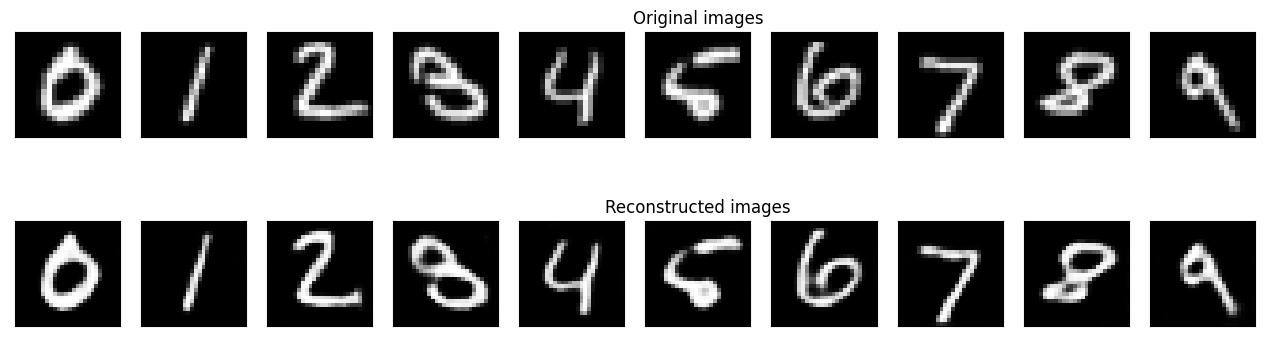

	 partial train loss (single batch): 0.005372
	 partial train loss (single batch): 0.005287
	 partial train loss (single batch): 0.005309
	 partial train loss (single batch): 0.005088
	 partial train loss (single batch): 0.005155
	 partial train loss (single batch): 0.005486
	 partial train loss (single batch): 0.005284
	 partial train loss (single batch): 0.005296
	 partial train loss (single batch): 0.005438
	 partial train loss (single batch): 0.004949
	 partial train loss (single batch): 0.005508
	 partial train loss (single batch): 0.005071
	 partial train loss (single batch): 0.005745
	 partial train loss (single batch): 0.005068
	 partial train loss (single batch): 0.005254
	 partial train loss (single batch): 0.005021
	 partial train loss (single batch): 0.005126
	 partial train loss (single batch): 0.005387
	 partial train loss (single batch): 0.005545
	 partial train loss (single batch): 0.005467
	 partial train loss (single batch): 0.005130
	 partial train loss (single batch

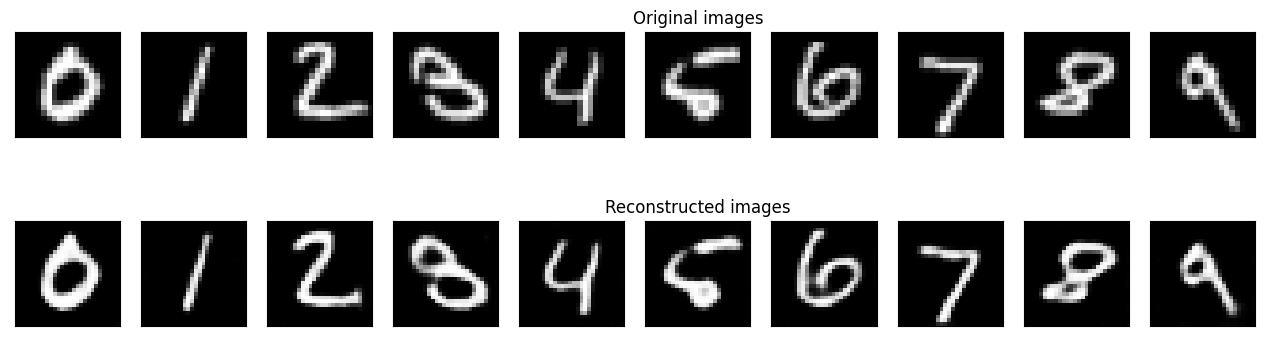

	 partial train loss (single batch): 0.005377
	 partial train loss (single batch): 0.005316
	 partial train loss (single batch): 0.005292
	 partial train loss (single batch): 0.005083
	 partial train loss (single batch): 0.005147
	 partial train loss (single batch): 0.005496
	 partial train loss (single batch): 0.005282
	 partial train loss (single batch): 0.005302
	 partial train loss (single batch): 0.005444
	 partial train loss (single batch): 0.004948
	 partial train loss (single batch): 0.005500
	 partial train loss (single batch): 0.005085
	 partial train loss (single batch): 0.005760
	 partial train loss (single batch): 0.005066
	 partial train loss (single batch): 0.005240
	 partial train loss (single batch): 0.005038
	 partial train loss (single batch): 0.005125
	 partial train loss (single batch): 0.005408
	 partial train loss (single batch): 0.005503
	 partial train loss (single batch): 0.005518
	 partial train loss (single batch): 0.005107
	 partial train loss (single batch

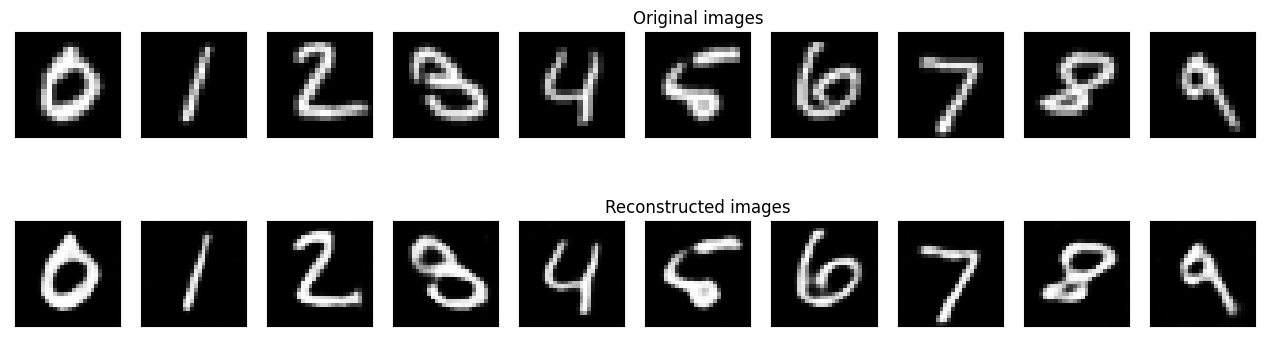

	 partial train loss (single batch): 0.005345
	 partial train loss (single batch): 0.005284
	 partial train loss (single batch): 0.005292
	 partial train loss (single batch): 0.005095
	 partial train loss (single batch): 0.005108
	 partial train loss (single batch): 0.005500
	 partial train loss (single batch): 0.005265
	 partial train loss (single batch): 0.005293
	 partial train loss (single batch): 0.005430
	 partial train loss (single batch): 0.004964
	 partial train loss (single batch): 0.005489
	 partial train loss (single batch): 0.005079
	 partial train loss (single batch): 0.005745
	 partial train loss (single batch): 0.005039
	 partial train loss (single batch): 0.005237
	 partial train loss (single batch): 0.004987
	 partial train loss (single batch): 0.005148
	 partial train loss (single batch): 0.005328
	 partial train loss (single batch): 0.005524
	 partial train loss (single batch): 0.005467
	 partial train loss (single batch): 0.005127
	 partial train loss (single batch

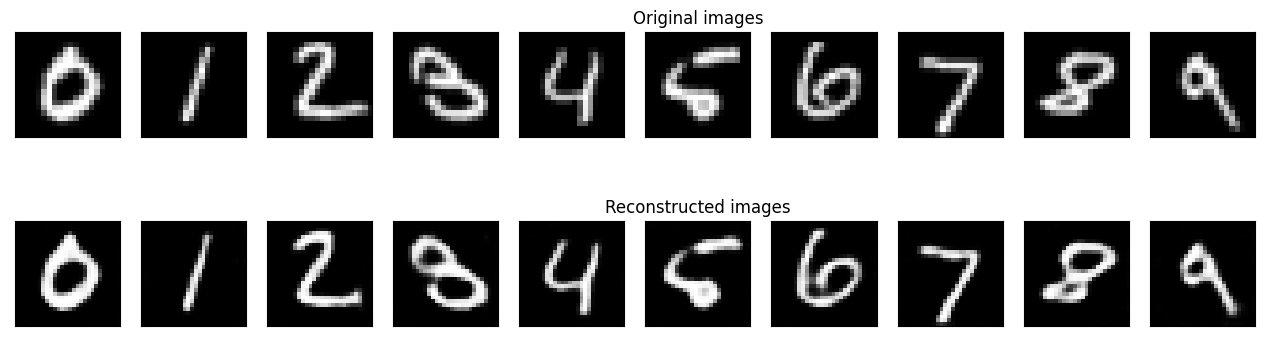

	 partial train loss (single batch): 0.005347
	 partial train loss (single batch): 0.005252
	 partial train loss (single batch): 0.005281
	 partial train loss (single batch): 0.005090
	 partial train loss (single batch): 0.005102
	 partial train loss (single batch): 0.005483
	 partial train loss (single batch): 0.005259
	 partial train loss (single batch): 0.005266
	 partial train loss (single batch): 0.005422
	 partial train loss (single batch): 0.004932
	 partial train loss (single batch): 0.005476
	 partial train loss (single batch): 0.005070
	 partial train loss (single batch): 0.005717
	 partial train loss (single batch): 0.005024
	 partial train loss (single batch): 0.005242
	 partial train loss (single batch): 0.004961
	 partial train loss (single batch): 0.005131
	 partial train loss (single batch): 0.005327
	 partial train loss (single batch): 0.005525
	 partial train loss (single batch): 0.005445
	 partial train loss (single batch): 0.005090
	 partial train loss (single batch

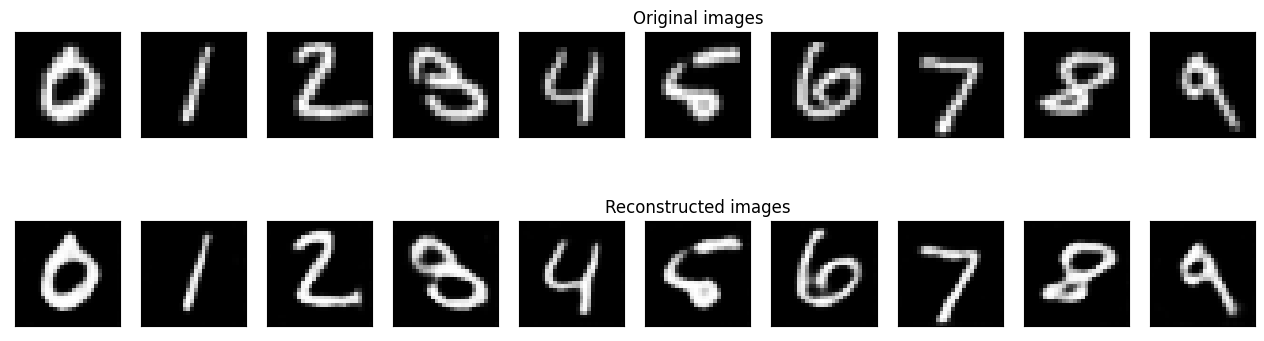

	 partial train loss (single batch): 0.005302
	 partial train loss (single batch): 0.005256
	 partial train loss (single batch): 0.005244
	 partial train loss (single batch): 0.005060
	 partial train loss (single batch): 0.005051
	 partial train loss (single batch): 0.005457
	 partial train loss (single batch): 0.005211
	 partial train loss (single batch): 0.005261
	 partial train loss (single batch): 0.005377
	 partial train loss (single batch): 0.004948
	 partial train loss (single batch): 0.005462
	 partial train loss (single batch): 0.005093
	 partial train loss (single batch): 0.005693
	 partial train loss (single batch): 0.005038
	 partial train loss (single batch): 0.005225
	 partial train loss (single batch): 0.004946
	 partial train loss (single batch): 0.005153
	 partial train loss (single batch): 0.005296
	 partial train loss (single batch): 0.005505
	 partial train loss (single batch): 0.005453
	 partial train loss (single batch): 0.005070
	 partial train loss (single batch

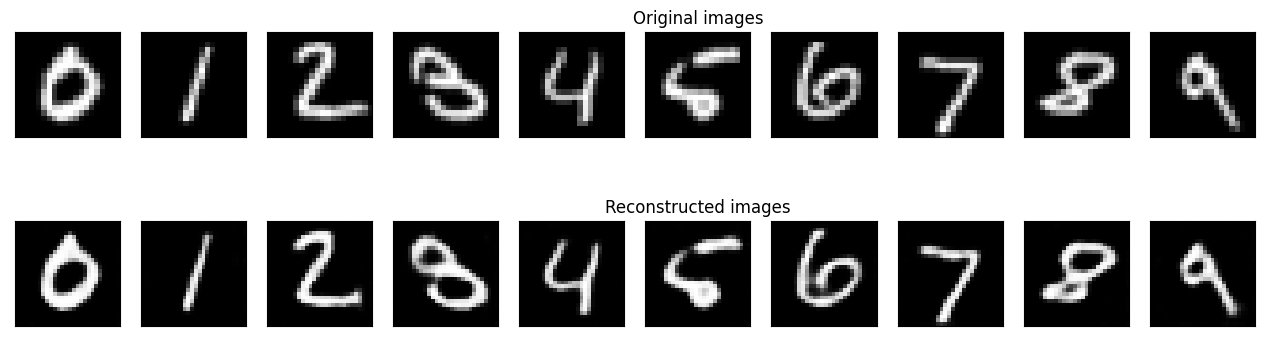

	 partial train loss (single batch): 0.005276
	 partial train loss (single batch): 0.005224
	 partial train loss (single batch): 0.005213
	 partial train loss (single batch): 0.005018
	 partial train loss (single batch): 0.005029
	 partial train loss (single batch): 0.005473
	 partial train loss (single batch): 0.005158
	 partial train loss (single batch): 0.005253
	 partial train loss (single batch): 0.005345
	 partial train loss (single batch): 0.004967
	 partial train loss (single batch): 0.005378
	 partial train loss (single batch): 0.005109
	 partial train loss (single batch): 0.005684
	 partial train loss (single batch): 0.005052
	 partial train loss (single batch): 0.005171
	 partial train loss (single batch): 0.004973
	 partial train loss (single batch): 0.005096
	 partial train loss (single batch): 0.005311
	 partial train loss (single batch): 0.005465
	 partial train loss (single batch): 0.005459
	 partial train loss (single batch): 0.005067
	 partial train loss (single batch

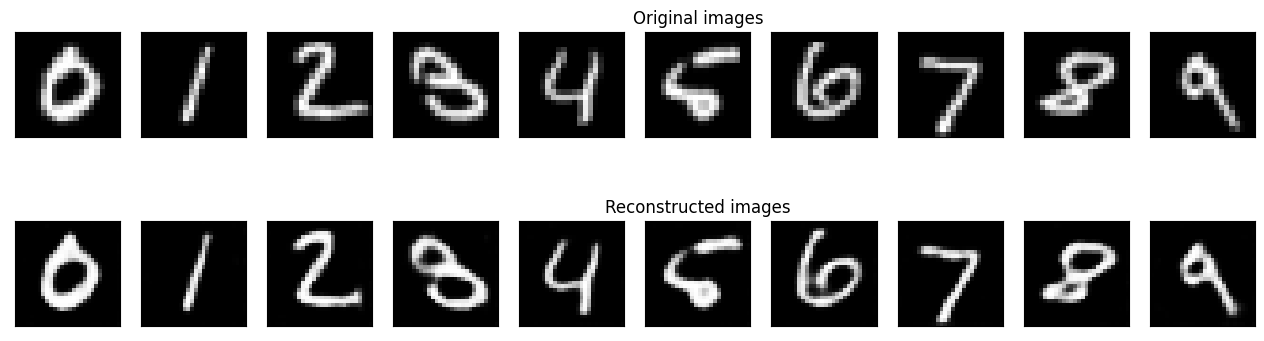

	 partial train loss (single batch): 0.005296
	 partial train loss (single batch): 0.005216
	 partial train loss (single batch): 0.005221
	 partial train loss (single batch): 0.005019
	 partial train loss (single batch): 0.005038
	 partial train loss (single batch): 0.005457
	 partial train loss (single batch): 0.005193
	 partial train loss (single batch): 0.005248
	 partial train loss (single batch): 0.005384
	 partial train loss (single batch): 0.004906
	 partial train loss (single batch): 0.005428
	 partial train loss (single batch): 0.005073
	 partial train loss (single batch): 0.005670
	 partial train loss (single batch): 0.005024
	 partial train loss (single batch): 0.005209
	 partial train loss (single batch): 0.004930
	 partial train loss (single batch): 0.005089
	 partial train loss (single batch): 0.005289
	 partial train loss (single batch): 0.005483
	 partial train loss (single batch): 0.005413
	 partial train loss (single batch): 0.005054
	 partial train loss (single batch

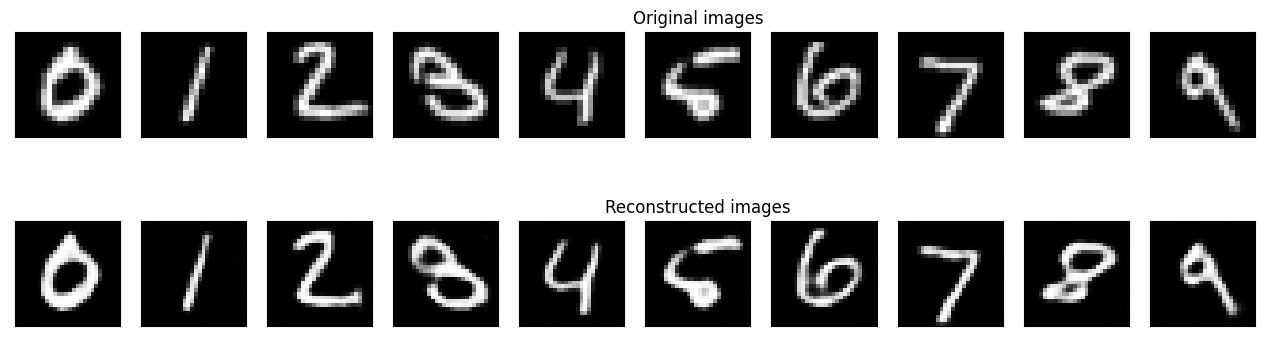

	 partial train loss (single batch): 0.005270
	 partial train loss (single batch): 0.005184
	 partial train loss (single batch): 0.005197
	 partial train loss (single batch): 0.005026
	 partial train loss (single batch): 0.005012
	 partial train loss (single batch): 0.005446
	 partial train loss (single batch): 0.005185
	 partial train loss (single batch): 0.005221
	 partial train loss (single batch): 0.005359
	 partial train loss (single batch): 0.004885
	 partial train loss (single batch): 0.005424
	 partial train loss (single batch): 0.005058
	 partial train loss (single batch): 0.005653
	 partial train loss (single batch): 0.005014
	 partial train loss (single batch): 0.005213
	 partial train loss (single batch): 0.004916
	 partial train loss (single batch): 0.005079
	 partial train loss (single batch): 0.005292
	 partial train loss (single batch): 0.005485
	 partial train loss (single batch): 0.005398
	 partial train loss (single batch): 0.005058
	 partial train loss (single batch

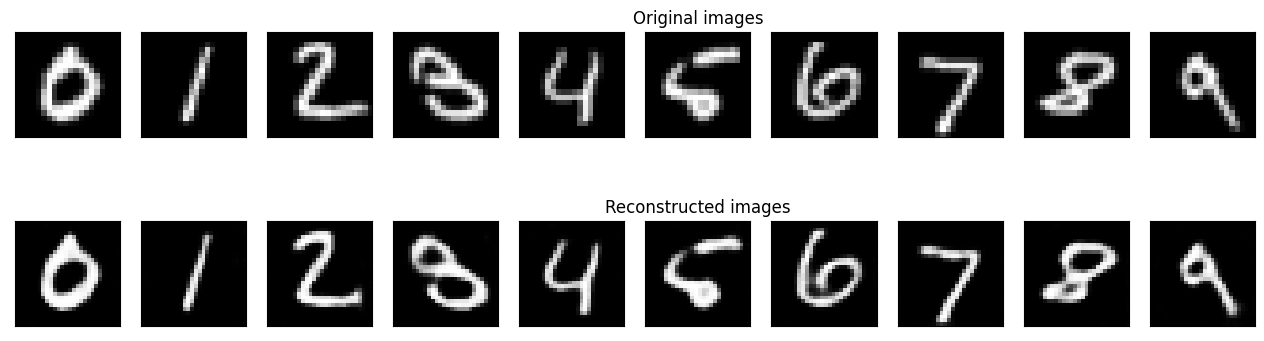

	 partial train loss (single batch): 0.005274
	 partial train loss (single batch): 0.005236
	 partial train loss (single batch): 0.005233
	 partial train loss (single batch): 0.005023
	 partial train loss (single batch): 0.005035
	 partial train loss (single batch): 0.005478
	 partial train loss (single batch): 0.005159
	 partial train loss (single batch): 0.005228
	 partial train loss (single batch): 0.005355
	 partial train loss (single batch): 0.004970
	 partial train loss (single batch): 0.005369
	 partial train loss (single batch): 0.005097
	 partial train loss (single batch): 0.005668
	 partial train loss (single batch): 0.005056
	 partial train loss (single batch): 0.005150
	 partial train loss (single batch): 0.004963
	 partial train loss (single batch): 0.005056
	 partial train loss (single batch): 0.005333
	 partial train loss (single batch): 0.005405
	 partial train loss (single batch): 0.005468
	 partial train loss (single batch): 0.005022
	 partial train loss (single batch

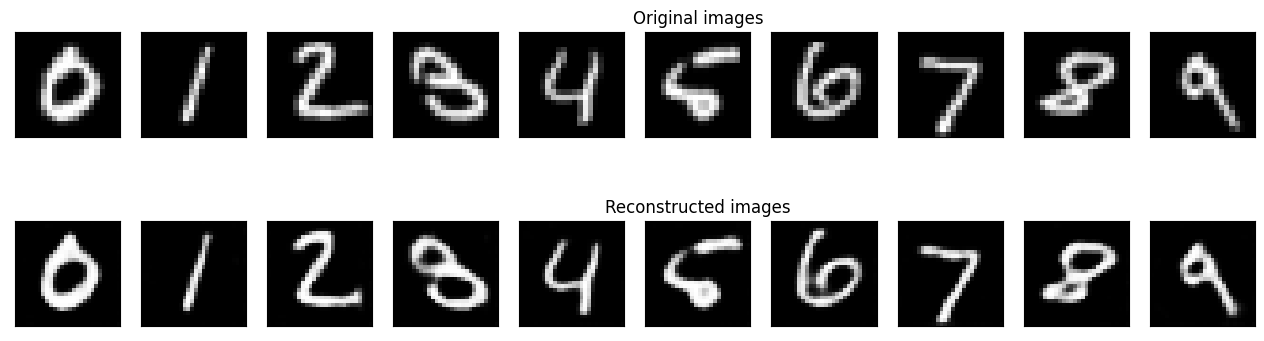

	 partial train loss (single batch): 0.005287
	 partial train loss (single batch): 0.005150
	 partial train loss (single batch): 0.005182
	 partial train loss (single batch): 0.005004
	 partial train loss (single batch): 0.004992
	 partial train loss (single batch): 0.005445
	 partial train loss (single batch): 0.005163
	 partial train loss (single batch): 0.005198
	 partial train loss (single batch): 0.005349
	 partial train loss (single batch): 0.004902
	 partial train loss (single batch): 0.005411
	 partial train loss (single batch): 0.005031
	 partial train loss (single batch): 0.005656
	 partial train loss (single batch): 0.005001
	 partial train loss (single batch): 0.005193
	 partial train loss (single batch): 0.004918
	 partial train loss (single batch): 0.005026
	 partial train loss (single batch): 0.005306
	 partial train loss (single batch): 0.005408
	 partial train loss (single batch): 0.005385
	 partial train loss (single batch): 0.005038
	 partial train loss (single batch

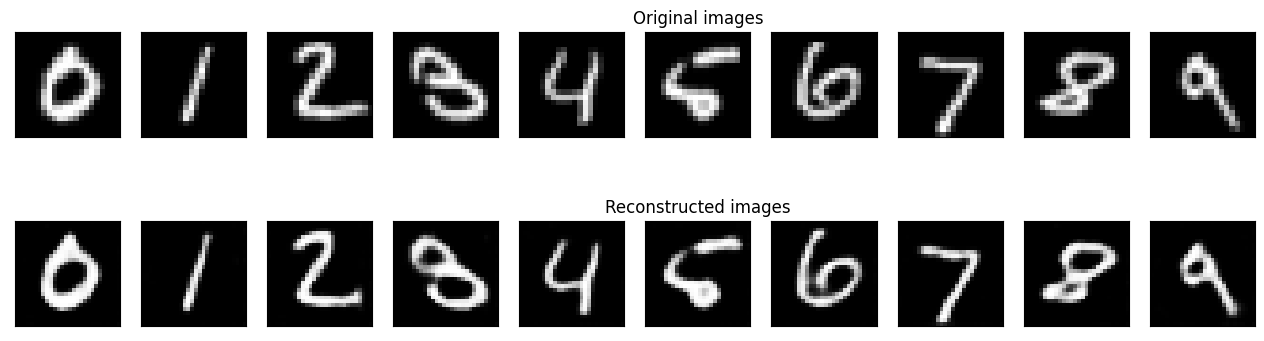

	 partial train loss (single batch): 0.005280
	 partial train loss (single batch): 0.005125
	 partial train loss (single batch): 0.005200
	 partial train loss (single batch): 0.004986
	 partial train loss (single batch): 0.004990
	 partial train loss (single batch): 0.005424
	 partial train loss (single batch): 0.005171
	 partial train loss (single batch): 0.005183
	 partial train loss (single batch): 0.005329
	 partial train loss (single batch): 0.004907
	 partial train loss (single batch): 0.005397
	 partial train loss (single batch): 0.005026
	 partial train loss (single batch): 0.005639
	 partial train loss (single batch): 0.004999
	 partial train loss (single batch): 0.005183
	 partial train loss (single batch): 0.004926
	 partial train loss (single batch): 0.004998
	 partial train loss (single batch): 0.005311
	 partial train loss (single batch): 0.005408
	 partial train loss (single batch): 0.005387
	 partial train loss (single batch): 0.005033
	 partial train loss (single batch

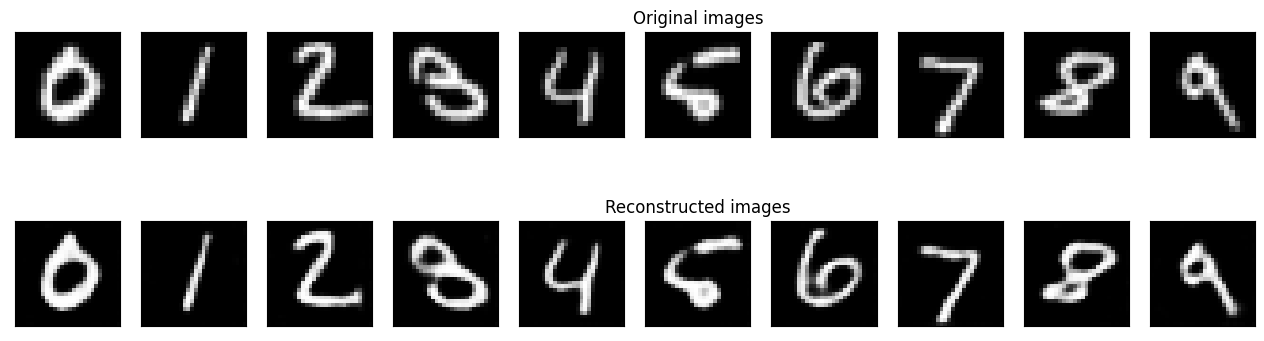

	 partial train loss (single batch): 0.005327
	 partial train loss (single batch): 0.005148
	 partial train loss (single batch): 0.005263
	 partial train loss (single batch): 0.004970
	 partial train loss (single batch): 0.005018
	 partial train loss (single batch): 0.005432
	 partial train loss (single batch): 0.005194
	 partial train loss (single batch): 0.005230
	 partial train loss (single batch): 0.005381
	 partial train loss (single batch): 0.004924
	 partial train loss (single batch): 0.005388
	 partial train loss (single batch): 0.005101
	 partial train loss (single batch): 0.005644
	 partial train loss (single batch): 0.005040
	 partial train loss (single batch): 0.005185
	 partial train loss (single batch): 0.004959
	 partial train loss (single batch): 0.004995
	 partial train loss (single batch): 0.005377
	 partial train loss (single batch): 0.005401
	 partial train loss (single batch): 0.005432
	 partial train loss (single batch): 0.005047
	 partial train loss (single batch

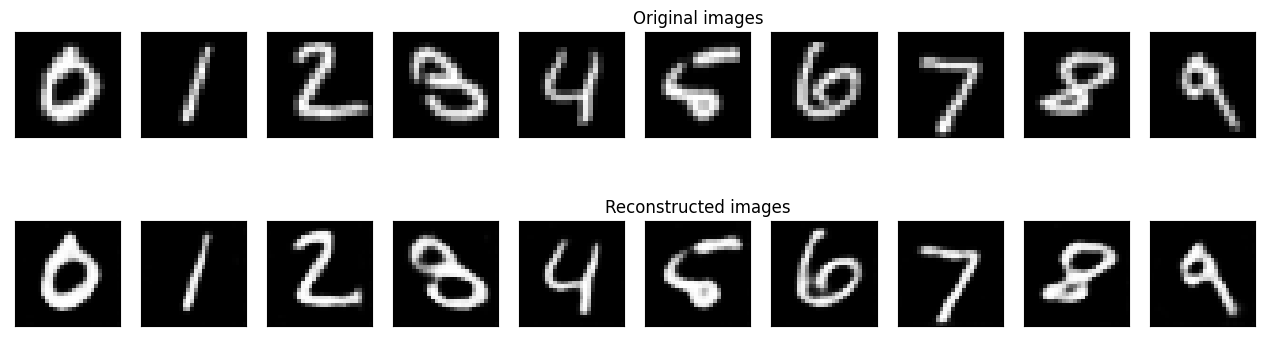

	 partial train loss (single batch): 0.005417
	 partial train loss (single batch): 0.005156
	 partial train loss (single batch): 0.005303
	 partial train loss (single batch): 0.005002
	 partial train loss (single batch): 0.005042
	 partial train loss (single batch): 0.005463
	 partial train loss (single batch): 0.005221
	 partial train loss (single batch): 0.005167
	 partial train loss (single batch): 0.005408
	 partial train loss (single batch): 0.004864
	 partial train loss (single batch): 0.005354
	 partial train loss (single batch): 0.005078
	 partial train loss (single batch): 0.005624
	 partial train loss (single batch): 0.005086
	 partial train loss (single batch): 0.005173
	 partial train loss (single batch): 0.004928
	 partial train loss (single batch): 0.005085
	 partial train loss (single batch): 0.005325
	 partial train loss (single batch): 0.005425
	 partial train loss (single batch): 0.005484
	 partial train loss (single batch): 0.005044
	 partial train loss (single batch

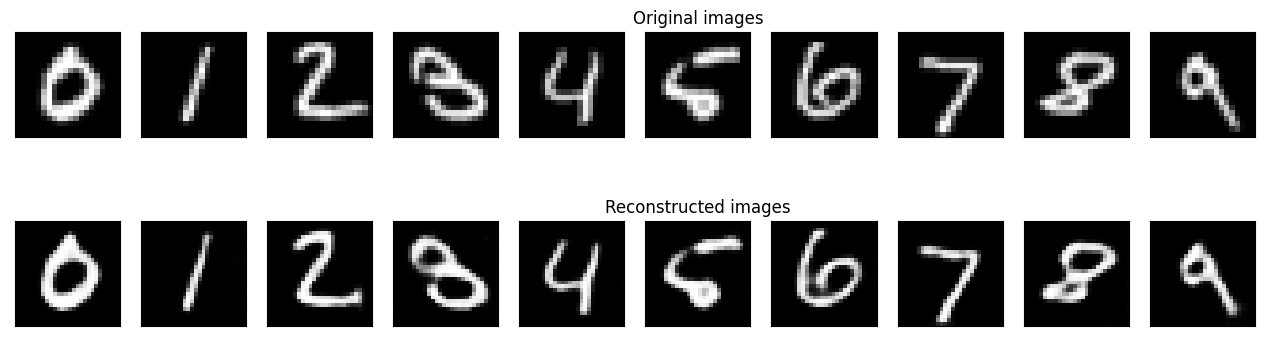

	 partial train loss (single batch): 0.005283
	 partial train loss (single batch): 0.005103
	 partial train loss (single batch): 0.005192
	 partial train loss (single batch): 0.004972
	 partial train loss (single batch): 0.004993
	 partial train loss (single batch): 0.005391
	 partial train loss (single batch): 0.005162
	 partial train loss (single batch): 0.005141
	 partial train loss (single batch): 0.005329
	 partial train loss (single batch): 0.004851
	 partial train loss (single batch): 0.005356
	 partial train loss (single batch): 0.005055
	 partial train loss (single batch): 0.005583
	 partial train loss (single batch): 0.005024
	 partial train loss (single batch): 0.005214
	 partial train loss (single batch): 0.004909
	 partial train loss (single batch): 0.005007
	 partial train loss (single batch): 0.005355
	 partial train loss (single batch): 0.005434
	 partial train loss (single batch): 0.005398
	 partial train loss (single batch): 0.005068
	 partial train loss (single batch

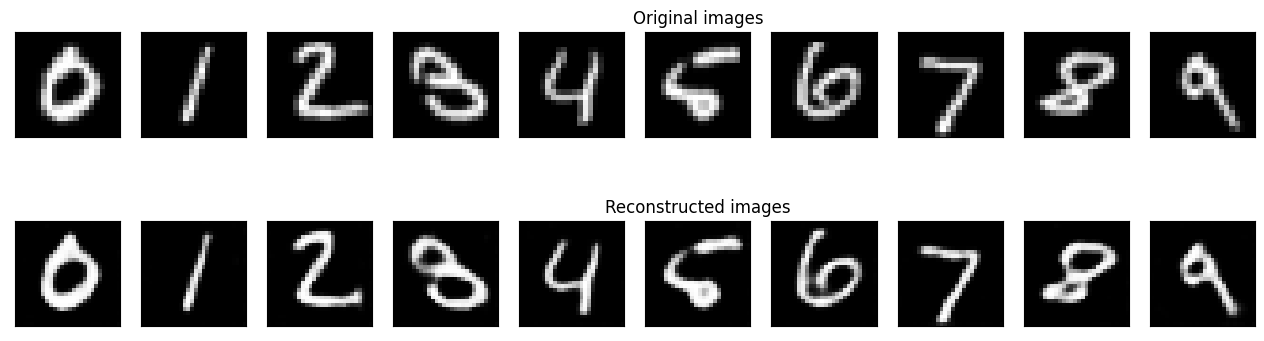

	 partial train loss (single batch): 0.005245
	 partial train loss (single batch): 0.005110
	 partial train loss (single batch): 0.005182
	 partial train loss (single batch): 0.004964
	 partial train loss (single batch): 0.004976
	 partial train loss (single batch): 0.005392
	 partial train loss (single batch): 0.005144
	 partial train loss (single batch): 0.005148
	 partial train loss (single batch): 0.005330
	 partial train loss (single batch): 0.004846
	 partial train loss (single batch): 0.005369
	 partial train loss (single batch): 0.005083
	 partial train loss (single batch): 0.005591
	 partial train loss (single batch): 0.005036
	 partial train loss (single batch): 0.005234
	 partial train loss (single batch): 0.004920
	 partial train loss (single batch): 0.005016
	 partial train loss (single batch): 0.005378
	 partial train loss (single batch): 0.005441
	 partial train loss (single batch): 0.005415
	 partial train loss (single batch): 0.005088
	 partial train loss (single batch

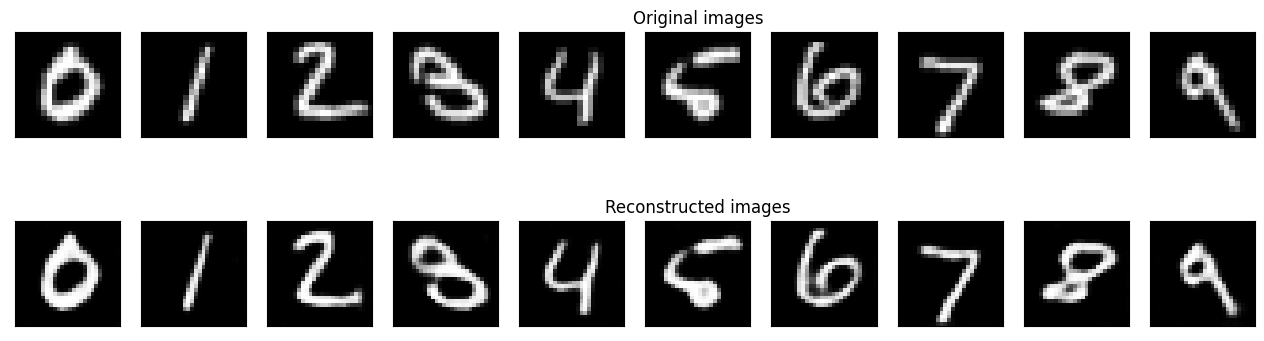

	 partial train loss (single batch): 0.005324
	 partial train loss (single batch): 0.005288
	 partial train loss (single batch): 0.005321
	 partial train loss (single batch): 0.005223
	 partial train loss (single batch): 0.005556
	 partial train loss (single batch): 0.005519
	 partial train loss (single batch): 0.005523
	 partial train loss (single batch): 0.005354
	 partial train loss (single batch): 0.005538
	 partial train loss (single batch): 0.005064
	 partial train loss (single batch): 0.005545
	 partial train loss (single batch): 0.005192
	 partial train loss (single batch): 0.005829
	 partial train loss (single batch): 0.005160
	 partial train loss (single batch): 0.005266
	 partial train loss (single batch): 0.005108
	 partial train loss (single batch): 0.005280
	 partial train loss (single batch): 0.005427
	 partial train loss (single batch): 0.005457
	 partial train loss (single batch): 0.005673
	 partial train loss (single batch): 0.005067
	 partial train loss (single batch

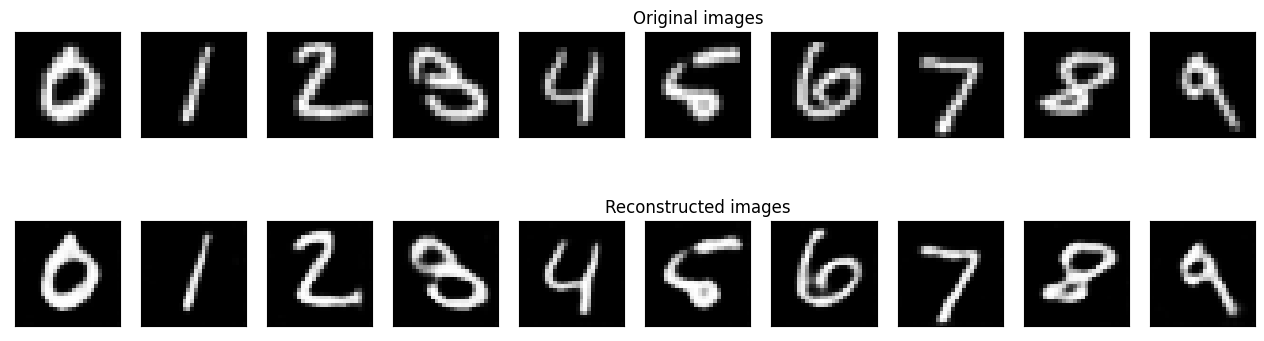

	 partial train loss (single batch): 0.005225
	 partial train loss (single batch): 0.005141
	 partial train loss (single batch): 0.005173
	 partial train loss (single batch): 0.004911
	 partial train loss (single batch): 0.004959
	 partial train loss (single batch): 0.005412
	 partial train loss (single batch): 0.005058
	 partial train loss (single batch): 0.005208
	 partial train loss (single batch): 0.005271
	 partial train loss (single batch): 0.004856
	 partial train loss (single batch): 0.005348
	 partial train loss (single batch): 0.005060
	 partial train loss (single batch): 0.005593
	 partial train loss (single batch): 0.005069
	 partial train loss (single batch): 0.005128
	 partial train loss (single batch): 0.004920
	 partial train loss (single batch): 0.005034
	 partial train loss (single batch): 0.005311
	 partial train loss (single batch): 0.005369
	 partial train loss (single batch): 0.005448
	 partial train loss (single batch): 0.005025
	 partial train loss (single batch

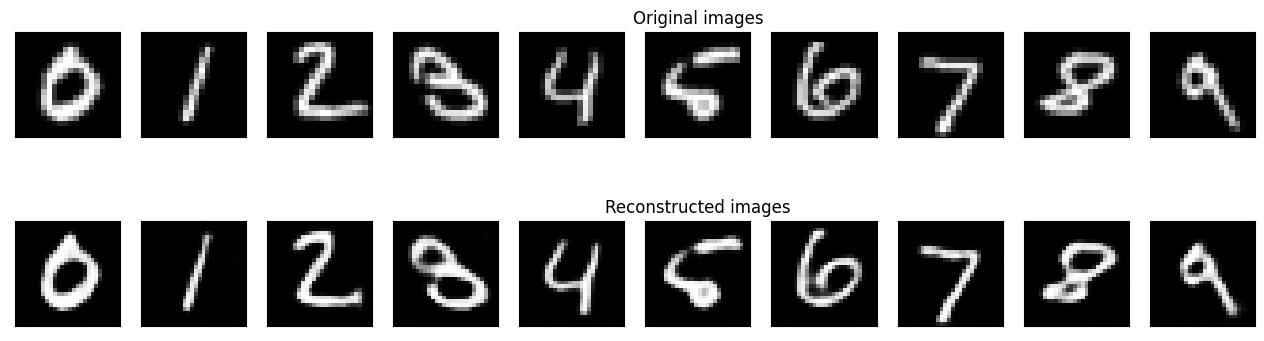

	 partial train loss (single batch): 0.005211
	 partial train loss (single batch): 0.005136
	 partial train loss (single batch): 0.005180
	 partial train loss (single batch): 0.004911
	 partial train loss (single batch): 0.004938
	 partial train loss (single batch): 0.005410
	 partial train loss (single batch): 0.005050
	 partial train loss (single batch): 0.005189
	 partial train loss (single batch): 0.005250
	 partial train loss (single batch): 0.004843
	 partial train loss (single batch): 0.005348
	 partial train loss (single batch): 0.005060
	 partial train loss (single batch): 0.005576
	 partial train loss (single batch): 0.005072
	 partial train loss (single batch): 0.005143
	 partial train loss (single batch): 0.004913
	 partial train loss (single batch): 0.005003
	 partial train loss (single batch): 0.005300
	 partial train loss (single batch): 0.005366
	 partial train loss (single batch): 0.005431
	 partial train loss (single batch): 0.004967
	 partial train loss (single batch

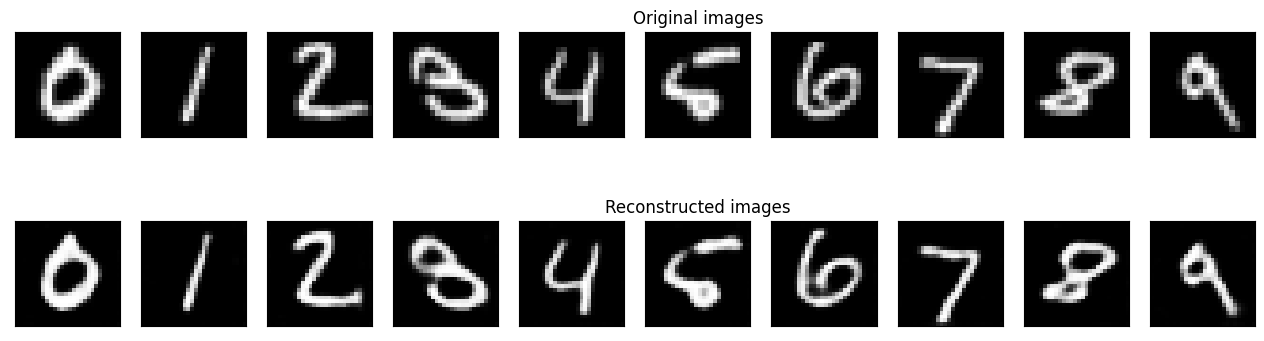

	 partial train loss (single batch): 0.005203
	 partial train loss (single batch): 0.005157
	 partial train loss (single batch): 0.005207
	 partial train loss (single batch): 0.004923
	 partial train loss (single batch): 0.004947
	 partial train loss (single batch): 0.005423
	 partial train loss (single batch): 0.005055
	 partial train loss (single batch): 0.005215
	 partial train loss (single batch): 0.005222
	 partial train loss (single batch): 0.004858
	 partial train loss (single batch): 0.005350
	 partial train loss (single batch): 0.005069
	 partial train loss (single batch): 0.005572
	 partial train loss (single batch): 0.005085
	 partial train loss (single batch): 0.005139
	 partial train loss (single batch): 0.004929
	 partial train loss (single batch): 0.004999
	 partial train loss (single batch): 0.005305
	 partial train loss (single batch): 0.005394
	 partial train loss (single batch): 0.005428
	 partial train loss (single batch): 0.004987
	 partial train loss (single batch

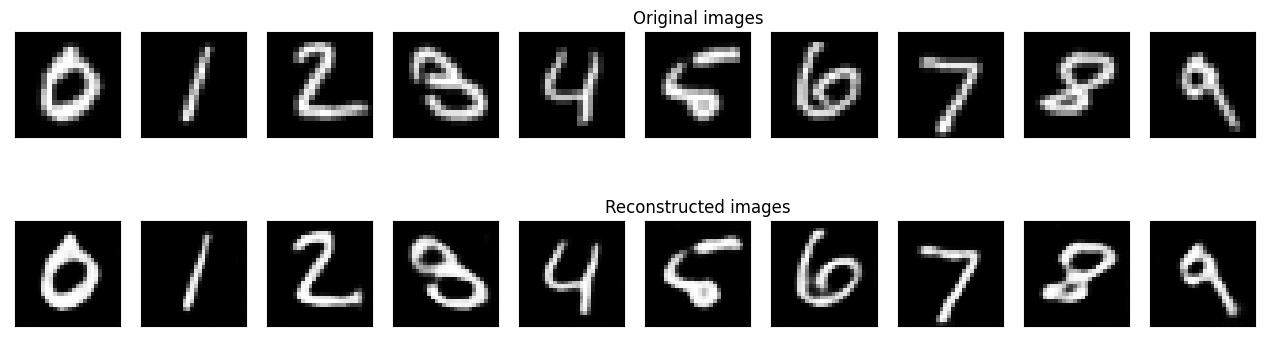

In [161]:
num_epochs = 50
# diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
   train_loss =train_epoch(encoder,decoder,device,
   train_loader,loss_fn,optim)
   val_loss = test_epoch(encoder,decoder,device,test_loader,loss_fn)
   print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
   diz_loss['train_loss'].append(train_loss)
   diz_loss['val_loss'].append(val_loss)
   plot_ae_outputs(encoder,decoder,n=10)

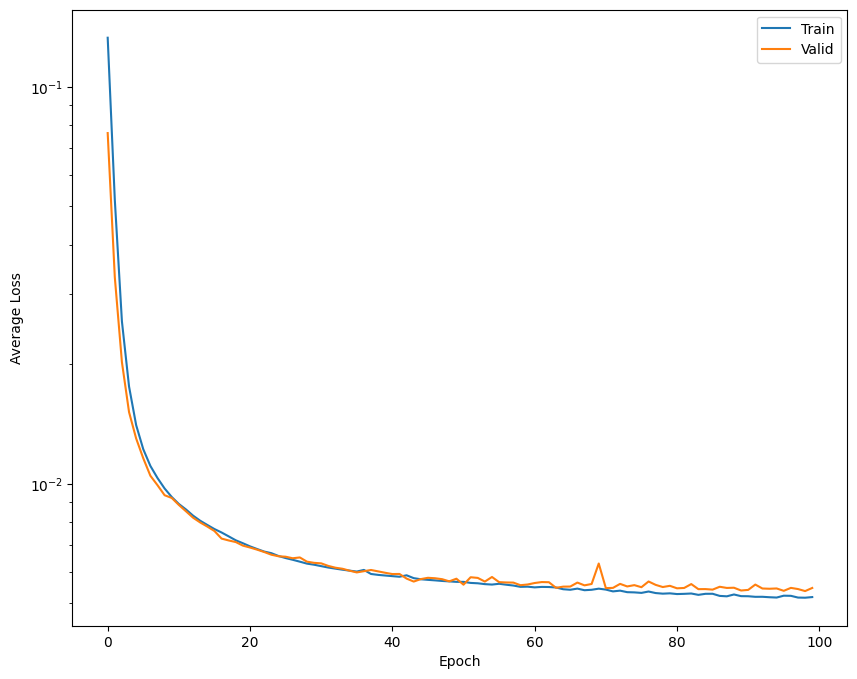

In [162]:
plt.figure(figsize=(10,8))
plt.semilogy(diz_loss['train_loss'], label='Train')
plt.semilogy(diz_loss['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

tensor([-0.0136,  0.0626,  0.0203, -0.1107, -0.0247,  0.0027,  0.0686,  0.0142,
         0.1851,  0.0028, -0.0049, -0.0077,  0.1065, -0.0020,  0.0064, -0.0452,
         0.0097, -0.0094, -0.0845,  0.0115, -0.0483, -0.0067, -0.0506, -0.0277,
        -0.1572,  0.0551,  0.0208,  0.0537,  0.0032, -0.0291,  0.0094, -0.0109])
tensor([0.1629, 0.1510, 0.1818, 0.1379, 0.1564, 0.1432, 0.1942, 0.1895, 0.1511,
        0.1373, 0.1537, 0.1778, 0.1895, 0.1627, 0.1484, 0.1450, 0.1873, 0.1560,
        0.1590, 0.1596, 0.1617, 0.1614, 0.1578, 0.1561, 0.1373, 0.1453, 0.1325,
        0.1759, 0.1468, 0.1837, 0.1351, 0.1364])


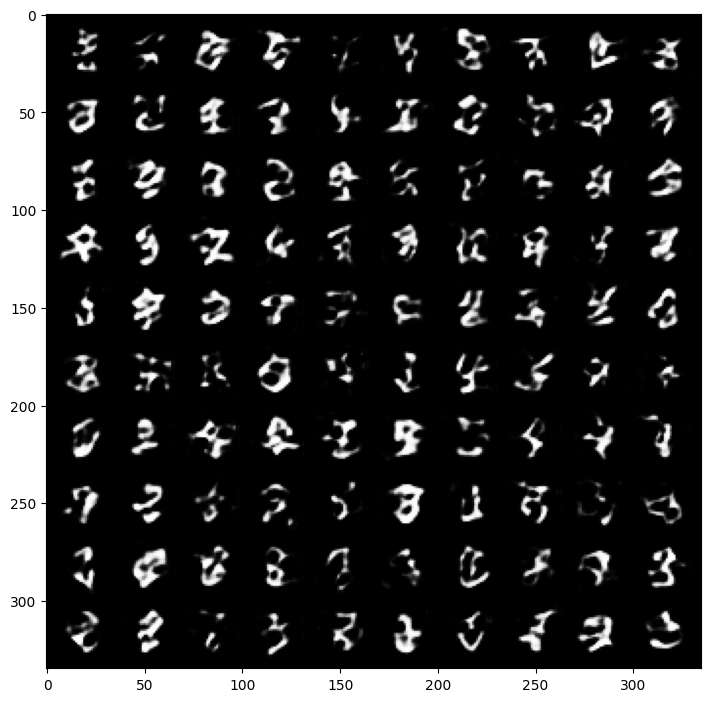

In [163]:
def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

encoder.eval()
decoder.eval()

with torch.no_grad():
    # calculate mean and std of latent code, generated takining in test images as inputs
    dataiter = iter(test_loader)
    images, small_images = next(dataiter)
    small_images = small_images.to(device)
    latent = encoder(small_images)
    latent = latent.cpu()

    mean = latent.mean(dim=0)
    print(mean)
    std = (latent - mean).pow(2).mean(dim=0).sqrt()
    print(std)

    # sample latent vectors from the normal distribution
    latent = torch.randn(128, d)*std + mean

    # reconstruct images from the random latent vectors
    latent = latent.to(device)
    img_recon = decoder(latent)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(20, 8.5))
    show_image(torchvision.utils.make_grid(img_recon[:100],10,5))
    plt.show()

In [127]:
from tqdm import tqdm

encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[1].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:04<00:00, 2056.73it/s]


,Enc. Variable 0,Enc. Variable 1,Enc. Variable 2,Enc. Variable 3,Enc. Variable 4,Enc. Variable 5,Enc. Variable 6,Enc. Variable 7,Enc. Variable 8,Enc. Variable 9,...,Enc. Variable 55,Enc. Variable 56,Enc. Variable 57,Enc. Variable 58,Enc. Variable 59,Enc. Variable 60,Enc. Variable 61,Enc. Variable 62,Enc. Variable 63,label
0,-0.103982,-0.076670,0.090924,0.084103,0.097793,-0.111462,0.192919,-0.150047,-0.055400,-0.026998,...,0.138711,-0.034872,0.219927,0.130704,0.112779,-0.221847,0.118815,-0.080572,0.084959,"[[[tensor(0.), tensor(0.), tensor(0.), tensor(..."
1,-0.300548,0.189705,-0.109290,-0.036732,-0.022761,-0.013169,0.041483,0.021415,-0.129538,0.167601,...,0.008071,0.293772,-0.071787,0.011273,0.210063,0.026195,0.153470,0.139646,-0.080058,"[[[tensor(0.), tensor(0.), tensor(0.), tensor(..."
2,-0.078625,-0.144482,-0.092244,-0.038552,0.034925,-0.074379,-0.136935,-0.138183,-0.037527,-0.142015,...,0.087918,-0.046045,0.095198,-0.025872,0.166851,-0.024745,0.020868,0.020103,-0.039936,"[[[tensor(0.), tensor(0.), tensor(0.), tensor(..."
3,-0.089900,-0.042633,0.057844,-0.048209,-0.042962,-0.014527,0.296565,-0.052837,0.008793,-0.101465,...,0.015282,-0.010044,0.013392,-0.066916,-0.084016,-0.113061,-0.020364,0.049633,-0.260880,"[[[tensor(0.), tensor(0.), tensor(0.), tensor(..."
4,-0.129866,-0.083424,0.123418,0.247851,0.051366,0.028479,0.105549,0.051734,-0.000729,0.038147,...,0.124616,0.146215,0.017824,0.114215,-0.053545,0.007266,0.074920,0.073808,-0.042982,"[[[tensor(0.), tensor(0.), tensor(0.), tensor(..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-0.291475,0.166420,0.130244,-0.117623,-0.069313,-0.056112,0.094834,0.062500,0.020774,-0.096898,...,-0.066842,0.206509,0.090203,-0.022675,0.182420,-0.206808,0.016719,0.114936,0.013922,"[[[tensor(0.), tensor(0.), tensor(0.), tensor(..."
9996,-0.056297,0.034699,-0.009103,-0.233957,0.035677,0.109376,0.208291,0.008764,0.046884,-0.010764,...,0.026404,0.117163,0.226924,-0.093301,0.094352,-0.186716,0.028551,0.265070,-0.226480,"[[[tensor(0.), tensor(0.), tensor(0.), tensor(..."
9997,0.024798,0.071945,0.041372,-0.079860,0.024982,-0.139098,-0.183830,-0.202014,0.094602,-0.003065,...,-0.077398,-0.033008,0.058402,0.120732,-0.207095,-0.017642,0.085276,-0.113175,0.016925,"[[[tensor(0.), tensor(0.), tensor(0.), tensor(..."
9998,-0.114435,0.032509,-0.189186,0.133144,-0.006487,0.017952,0.105430,-0.311832,-0.058925,0.047087,...,-0.005069,0.001952,0.142858,0.068197,-0.062490,-0.241479,-0.044486,-0.062369,0.138922,"[[[tensor(0.), tensor(0.), tensor(0.), tensor(..."


In [ ]:
import plotly.express as px

px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1',
           color=encoded_samples.label.astype(str), opacity=0.7)

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))
fig = px.scatter(tsne_results, x=0, y=1,
                 color=encoded_samples.label.astype(str),
                 labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
fig.show()